In [1]:

import torch
import torch.nn as nn
import torchvision.transforms as transforms
import timm
import torchsummary
import imageio
import numpy as np
import matplotlib.pyplot as plt
import os
from torch.cuda.amp import GradScaler, autocast

from tqdm.notebook import tqdm

from sklearn.model_selection import train_test_split, KFold

import sys
sys.path.append('../DataLoader')

from dataloader_fits import SunImageDataset

from torch.func import stack_module_state
from torch.func import vmap

from lightning.fabric import Fabric

In [2]:
torch.set_float32_matmul_precision('medium')
fabric = Fabric(accelerator='cuda', devices=1, precision="bf16-mixed")
fabric.launch()
print(fabric.device)

Using bfloat16 Automatic Mixed Precision (AMP)


cuda:0


In [ ]:
# Hyper-parameters
input_size = 224*224
hidden_size = 166
# hidden_size = 1024
num_epochs = 9
batch_size = 2
learning_rate = 0.001
dropout = 0.5
lstm_layers = 2
# dropout = 0.6990787087509548

In [4]:
dataset = SunImageDataset(csv_file="D:\\New folder (2)\\dataset.csv", offset=0, transform=transforms.ToTensor())
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size

# # Without Validation Set
# trainset, testset = torch.utils.data.Subset(dataset, range(train_size)), torch.utils.data.Subset(dataset, range(train_size, len(dataset)))
# trainloader = torch.utils.data.DataLoader(dataset=trainset, batch_size=batch_size, shuffle=True, num_workers=10)

# trainloader = fabric.setup_dataloaders(trainloader)

# With Validation Set
# Split dataset into training and test sets
train_indices, test_indices = train_test_split(range(len(dataset)), test_size=0.2, shuffle=False)

# Further split training set into training and validation sets
train_indices, val_indices = train_test_split(train_indices, test_size=0.25, shuffle=False)  # 0.25 x 0.8 = 0.2

trainset = torch.utils.data.Subset(dataset, train_indices)
valset = torch.utils.data.Subset(dataset, val_indices)
testset = torch.utils.data.Subset(dataset, test_indices)

trainloader = torch.utils.data.DataLoader(dataset=trainset, batch_size=batch_size, shuffle=True, num_workers=10)
valloader = torch.utils.data.DataLoader(dataset=valset, batch_size=batch_size, shuffle=False, num_workers=10)

trainloader = fabric.setup_dataloaders(trainloader)
valloader = fabric.setup_dataloaders(valloader)


# # Get a batch of training data
# dataiter = iter(trainloader)
# images, labels = next(dataiter)
# images = torch.stack(images)
# print(images.shape)
# print(labels.shape)

# print(images)
# print(labels)

In [5]:

class GmiSwinTransformer(nn.Module):
    def __init__(self, hidden_size: int):
        super(GmiSwinTransformer, self).__init__()
        
        # Batch normalization for 3 channels
        self.bn = nn.BatchNorm2d(3)
        
        # Initialize Swin Transformer
        self.pretrained_model = timm.create_model(
            'swin_base_patch4_window7_224',
            pretrained=True,
            num_classes=hidden_size
        )
        
        self.lstm = nn.LSTM(hidden_size, hidden_size * 2, lstm_layers, batch_first=True)
        
        # Fully connected layers
        self.fc = nn.Sequential(
            nn.LeakyReLU(),
            nn.Linear(hidden_size*2, hidden_size),
            nn.Dropout(p=dropout),  # Added dropout probability
            nn.LeakyReLU(),
            nn.Linear(hidden_size, 1),
            # nn.LeakyReLU()
            
        )
    
    def forward(self, images) -> torch.Tensor:
        """
        Batch should be in format:
        {
            'images': torch.FloatTensor((10, 1, 224, 224))
        }
        """
        
        batch_size = images.shape[0]
        
        images = images.reshape(-1, 1, 224, 224)
        images = torch.cat([images, images, images], dim=1)
        normalized_images = self.bn(images)
        features = self.pretrained_model(normalized_images)
        image_features = features.view(batch_size, 10, -1)
        # hidden_states = torch.zeros(lstm_layers, image_features.size(0), hidden_size * 2)
        # cell_states = torch.zeros(lstm_layers, image_features.size(0), hidden_size * 2)
        # image_features, _ = self.lstm(image_features, (hidden_states, cell_states))
        image_features, _ = self.lstm(image_features)

        image_features = image_features[:, -1, :]
        output = self.fc(image_features)
        return output

# Initialize model
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# model = GmiSwinTransformer(hidden_size=hidden_size).to(device)
model = GmiSwinTransformer(hidden_size=hidden_size)

# print(torchsummary.summary(model, (10, 1, 224, 224)))

# Loss and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

model, optimizer = fabric.setup(model, optimizer)
model.train()

_FabricModule(
  (_forward_module): GmiSwinTransformer(
    (bn): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (pretrained_model): SwinTransformer(
      (patch_embed): PatchEmbed(
        (proj): Conv2d(3, 128, kernel_size=(4, 4), stride=(4, 4))
        (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      )
      (layers): Sequential(
        (0): SwinTransformerStage(
          (downsample): Identity()
          (blocks): Sequential(
            (0): SwinTransformerBlock(
              (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
              (attn): WindowAttention(
                (qkv): Linear(in_features=128, out_features=384, bias=True)
                (attn_drop): Dropout(p=0.0, inplace=False)
                (proj): Linear(in_features=128, out_features=128, bias=True)
                (proj_drop): Dropout(p=0.0, inplace=False)
                (softmax): Softmax(dim=-1)
              )
              (drop_pa

In [6]:
torch.cuda.empty_cache()

Training Progress:   0%|          | 0/600 [00:00<?, ?it/s]

Epoch: 1, Index: 0, Loss: 9.7317
Epoch: 1, Index: 1, Loss: 25.6552
Epoch: 1, Index: 2, Loss: 10.9183
Epoch: 1, Index: 3, Loss: 8.6302
Epoch: 1, Index: 4, Loss: 6.5508
Epoch: 1, Index: 5, Loss: 5.4101
Epoch: 1, Index: 6, Loss: 7.1116
Epoch: 1, Index: 7, Loss: 3.3374
Epoch: 1, Index: 8, Loss: 3.1706
Epoch: 1, Index: 9, Loss: 4.9486
Epoch: 1, Index: 10, Loss: 13.5012
Epoch: 1, Index: 11, Loss: 2.1972
Epoch: 1, Index: 12, Loss: 9.1906
Epoch: 1, Index: 13, Loss: 12.4777
Epoch: 1, Index: 14, Loss: 2.6289
Epoch: 1, Index: 15, Loss: 13.1806
Epoch: 1, Index: 16, Loss: 2.0725
Epoch: 1, Index: 17, Loss: 12.3634
Epoch: 1, Index: 18, Loss: 22.3300
Epoch: 1, Index: 19, Loss: 13.8697
Epoch: 1, Index: 20, Loss: 15.3398
Epoch: 1, Index: 21, Loss: 8.8045
Epoch: 1, Index: 22, Loss: 8.1408
Epoch: 1, Index: 23, Loss: 9.6191
Epoch: 1, Index: 24, Loss: 8.2896
Epoch: 1, Index: 25, Loss: 16.9198
Epoch: 1, Index: 26, Loss: 7.4047
Epoch: 1, Index: 27, Loss: 10.5271
Epoch: 1, Index: 28, Loss: 3.4120
Epoch: 1, Ind

Validation Progress:   0%|          | 0/200 [00:00<?, ?it/s]

Validation Loss:  0.4733283221721649
Validation Loss:  0.6690245866775513
Validation Loss:  0.3689376413822174
Validation Loss:  0.4482611417770386
Validation Loss:  0.2971828281879425
Validation Loss:  0.7862658500671387
Validation Loss:  0.8015549182891846
Validation Loss:  0.3658447265625
Validation Loss:  3.077359676361084
Validation Loss:  4.731789588928223
Validation Loss:  1.6868215799331665
Validation Loss:  1.2561430931091309
Validation Loss:  1.3669641017913818
Validation Loss:  1.7364501953125
Validation Loss:  1.6097043752670288
Validation Loss:  2.2677001953125
Validation Loss:  0.26086562871932983
Validation Loss:  1.456569790840149
Validation Loss:  1.256234884262085
Validation Loss:  1.3179799318313599
Validation Loss:  1.0747580528259277
Validation Loss:  0.15415562689304352
Validation Loss:  0.660400390625
Validation Loss:  2.7555627822875977
Validation Loss:  0.375244140625
Validation Loss:  3.7890427112579346
Validation Loss:  0.13445326685905457
Validation Loss:  0

Training Progress:   0%|          | 0/600 [00:00<?, ?it/s]

Epoch: 2, Index: 0, Loss: 1.6767
Epoch: 2, Index: 1, Loss: 0.4988
Epoch: 2, Index: 2, Loss: 3.9389
Epoch: 2, Index: 3, Loss: 1.2140
Epoch: 2, Index: 4, Loss: 0.1279
Epoch: 2, Index: 5, Loss: 1.3424
Epoch: 2, Index: 6, Loss: 0.7642
Epoch: 2, Index: 7, Loss: 1.4399
Epoch: 2, Index: 8, Loss: 0.1868
Epoch: 2, Index: 9, Loss: 0.1069
Epoch: 2, Index: 10, Loss: 3.4951
Epoch: 2, Index: 11, Loss: 0.5520
Epoch: 2, Index: 12, Loss: 0.4322
Epoch: 2, Index: 13, Loss: 0.0412
Epoch: 2, Index: 14, Loss: 0.5903
Epoch: 2, Index: 15, Loss: 10.5353
Epoch: 2, Index: 16, Loss: 1.5108
Epoch: 2, Index: 17, Loss: 0.1180
Epoch: 2, Index: 18, Loss: 1.1973
Epoch: 2, Index: 19, Loss: 2.4708
Epoch: 2, Index: 20, Loss: 2.6911
Epoch: 2, Index: 21, Loss: 0.4386
Epoch: 2, Index: 22, Loss: 1.7700
Epoch: 2, Index: 23, Loss: 0.3301
Epoch: 2, Index: 24, Loss: 2.8023
Epoch: 2, Index: 25, Loss: 11.6671
Epoch: 2, Index: 26, Loss: 0.7165
Epoch: 2, Index: 27, Loss: 4.1497
Epoch: 2, Index: 28, Loss: 0.1198
Epoch: 2, Index: 29, L

Validation Progress:   0%|          | 0/200 [00:00<?, ?it/s]

Validation Loss:  0.19685271382331848
Validation Loss:  0.7160080075263977
Validation Loss:  0.20788298547267914
Validation Loss:  0.4867894649505615
Validation Loss:  0.4275549054145813
Validation Loss:  0.6234093904495239
Validation Loss:  0.6627765893936157
Validation Loss:  0.2408447265625
Validation Loss:  2.628326177597046
Validation Loss:  4.867195129394531
Validation Loss:  1.5179963111877441
Validation Loss:  0.877812922000885
Validation Loss:  0.8734679818153381
Validation Loss:  1.3643798828125
Validation Loss:  1.2970354557037354
Validation Loss:  2.620361328125
Validation Loss:  0.07218688726425171
Validation Loss:  1.3344535827636719
Validation Loss:  0.8080804944038391
Validation Loss:  1.084944725036621
Validation Loss:  1.0804524421691895
Validation Loss:  0.05259312316775322
Validation Loss:  0.3433837890625
Validation Loss:  1.9395666122436523
Validation Loss:  0.269775390625
Validation Loss:  3.9733083248138428
Validation Loss:  0.31151479482650757
Validation Loss: 

Training Progress:   0%|          | 0/600 [00:00<?, ?it/s]

Epoch: 3, Index: 0, Loss: 0.7351
Epoch: 3, Index: 1, Loss: 2.3343
Epoch: 3, Index: 2, Loss: 3.0067
Epoch: 3, Index: 3, Loss: 0.4441
Epoch: 3, Index: 4, Loss: 3.1464
Epoch: 3, Index: 5, Loss: 0.5641
Epoch: 3, Index: 6, Loss: 0.9264
Epoch: 3, Index: 7, Loss: 0.3342
Epoch: 3, Index: 8, Loss: 0.0760
Epoch: 3, Index: 9, Loss: 1.2211
Epoch: 3, Index: 10, Loss: 2.1052
Epoch: 3, Index: 11, Loss: 1.1895
Epoch: 3, Index: 12, Loss: 10.4501
Epoch: 3, Index: 13, Loss: 0.8746
Epoch: 3, Index: 14, Loss: 8.3347
Epoch: 3, Index: 15, Loss: 0.0503
Epoch: 3, Index: 16, Loss: 2.2970
Epoch: 3, Index: 17, Loss: 1.3498
Epoch: 3, Index: 18, Loss: 0.2556
Epoch: 3, Index: 19, Loss: 0.0981
Epoch: 3, Index: 20, Loss: 0.7942
Epoch: 3, Index: 21, Loss: 3.4680
Epoch: 3, Index: 22, Loss: 0.3329
Epoch: 3, Index: 23, Loss: 1.3038
Epoch: 3, Index: 24, Loss: 1.6338
Epoch: 3, Index: 25, Loss: 2.3186
Epoch: 3, Index: 26, Loss: 5.2170
Epoch: 3, Index: 27, Loss: 0.8473
Epoch: 3, Index: 28, Loss: 3.5151
Epoch: 3, Index: 29, Lo

Validation Progress:   0%|          | 0/200 [00:00<?, ?it/s]

Validation Loss:  0.018917152658104897
Validation Loss:  1.0192337036132812
Validation Loss:  0.14929217100143433
Validation Loss:  0.6000394821166992
Validation Loss:  0.8036096096038818
Validation Loss:  0.628826379776001
Validation Loss:  0.7386584281921387
Validation Loss:  0.297119140625
Validation Loss:  1.8023273944854736
Validation Loss:  5.274327754974365
Validation Loss:  1.5834543704986572
Validation Loss:  0.4580228328704834
Validation Loss:  0.3131711483001709
Validation Loss:  1.0260009765625
Validation Loss:  0.8429015874862671
Validation Loss:  3.349853515625
Validation Loss:  0.006888990756124258
Validation Loss:  1.46915864944458
Validation Loss:  0.39361560344696045
Validation Loss:  0.9869173765182495
Validation Loss:  1.1639378070831299
Validation Loss:  0.07574057579040527
Validation Loss:  0.05517578125
Validation Loss:  1.0746955871582031
Validation Loss:  0.2799072265625
Validation Loss:  4.609874725341797
Validation Loss:  0.8138008713722229
Validation Loss:  

Training Progress:   0%|          | 0/600 [00:00<?, ?it/s]

Epoch: 4, Index: 0, Loss: 2.5647
Epoch: 4, Index: 1, Loss: 0.2159
Epoch: 4, Index: 2, Loss: 2.0675
Epoch: 4, Index: 3, Loss: 1.6869
Epoch: 4, Index: 4, Loss: 8.3504
Epoch: 4, Index: 5, Loss: 0.1398
Epoch: 4, Index: 6, Loss: 2.9407
Epoch: 4, Index: 7, Loss: 0.9213
Epoch: 4, Index: 8, Loss: 2.6401
Epoch: 4, Index: 9, Loss: 1.7094
Epoch: 4, Index: 10, Loss: 5.0315
Epoch: 4, Index: 11, Loss: 1.7097
Epoch: 4, Index: 12, Loss: 1.9061
Epoch: 4, Index: 13, Loss: 1.5237
Epoch: 4, Index: 14, Loss: 0.4042
Epoch: 4, Index: 15, Loss: 0.2960
Epoch: 4, Index: 16, Loss: 1.5790
Epoch: 4, Index: 17, Loss: 0.7906
Epoch: 4, Index: 18, Loss: 2.0510
Epoch: 4, Index: 19, Loss: 1.1284
Epoch: 4, Index: 20, Loss: 2.3813
Epoch: 4, Index: 21, Loss: 0.1186
Epoch: 4, Index: 22, Loss: 0.1189
Epoch: 4, Index: 23, Loss: 3.8274
Epoch: 4, Index: 24, Loss: 1.6720
Epoch: 4, Index: 25, Loss: 2.2617
Epoch: 4, Index: 26, Loss: 1.2489
Epoch: 4, Index: 27, Loss: 2.9395
Epoch: 4, Index: 28, Loss: 2.3621
Epoch: 4, Index: 29, Los

Validation Progress:   0%|          | 0/200 [00:00<?, ?it/s]

Validation Loss:  0.15853826701641083
Validation Loss:  0.8405354022979736
Validation Loss:  0.2927072048187256
Validation Loss:  0.4318119287490845
Validation Loss:  0.4479103684425354
Validation Loss:  0.6729240417480469
Validation Loss:  0.6160852313041687
Validation Loss:  0.221923828125
Validation Loss:  3.0162034034729004
Validation Loss:  5.053520202636719
Validation Loss:  1.5116496086120605
Validation Loss:  1.0302797555923462
Validation Loss:  0.8588654398918152
Validation Loss:  1.4371337890625
Validation Loss:  1.3954700231552124
Validation Loss:  2.2725830078125
Validation Loss:  0.0904368907213211
Validation Loss:  1.385128378868103
Validation Loss:  0.7560931444168091
Validation Loss:  1.17388916015625
Validation Loss:  1.1142961978912354
Validation Loss:  0.04264390096068382
Validation Loss:  0.3624267578125
Validation Loss:  1.8964298963546753
Validation Loss:  0.3404541015625
Validation Loss:  3.7397429943084717
Validation Loss:  0.2776251435279846
Validation Loss:  0

Training Progress:   0%|          | 0/600 [00:00<?, ?it/s]

Epoch: 5, Index: 0, Loss: 0.9853
Epoch: 5, Index: 1, Loss: 1.0717
Epoch: 5, Index: 2, Loss: 1.2668
Epoch: 5, Index: 3, Loss: 1.1394
Epoch: 5, Index: 4, Loss: 2.2041
Epoch: 5, Index: 5, Loss: 0.4739
Epoch: 5, Index: 6, Loss: 5.4562
Epoch: 5, Index: 7, Loss: 1.6051
Epoch: 5, Index: 8, Loss: 0.3566
Epoch: 5, Index: 9, Loss: 0.1657
Epoch: 5, Index: 10, Loss: 1.9435
Epoch: 5, Index: 11, Loss: 0.6543
Epoch: 5, Index: 12, Loss: 0.4153
Epoch: 5, Index: 13, Loss: 1.5178
Epoch: 5, Index: 14, Loss: 1.5518
Epoch: 5, Index: 15, Loss: 6.3926
Epoch: 5, Index: 16, Loss: 2.1773
Epoch: 5, Index: 17, Loss: 1.7299
Epoch: 5, Index: 18, Loss: 0.1978
Epoch: 5, Index: 19, Loss: 0.5113
Epoch: 5, Index: 20, Loss: 7.0286
Epoch: 5, Index: 21, Loss: 0.3645
Epoch: 5, Index: 22, Loss: 0.9570
Epoch: 5, Index: 23, Loss: 0.5122
Epoch: 5, Index: 24, Loss: 0.6165
Epoch: 5, Index: 25, Loss: 0.3157
Epoch: 5, Index: 26, Loss: 0.4559
Epoch: 5, Index: 27, Loss: 0.8725
Epoch: 5, Index: 28, Loss: 0.3864
Epoch: 5, Index: 29, Los

Validation Progress:   0%|          | 0/200 [00:00<?, ?it/s]

Validation Loss:  0.2633673846721649
Validation Loss:  0.8041574358940125
Validation Loss:  0.443402498960495
Validation Loss:  0.36239880323410034
Validation Loss:  0.3432648479938507
Validation Loss:  0.6762209534645081
Validation Loss:  0.5962492823600769
Validation Loss:  0.28515625
Validation Loss:  3.718959093093872
Validation Loss:  5.061104774475098
Validation Loss:  1.4504172801971436
Validation Loss:  1.227745532989502
Validation Loss:  1.0255968570709229
Validation Loss:  1.5869140625
Validation Loss:  2.1109416484832764
Validation Loss:  1.7291259765625
Validation Loss:  0.19326795637607574
Validation Loss:  1.397045373916626
Validation Loss:  0.9150306582450867
Validation Loss:  1.5294535160064697
Validation Loss:  1.206836223602295
Validation Loss:  0.14893686771392822
Validation Loss:  0.5284423828125
Validation Loss:  1.9979777336120605
Validation Loss:  0.402587890625
Validation Loss:  3.422299385070801
Validation Loss:  0.16442103683948517
Validation Loss:  0.39368373

Training Progress:   0%|          | 0/600 [00:00<?, ?it/s]

Epoch: 6, Index: 0, Loss: 0.2544
Epoch: 6, Index: 1, Loss: 2.3201
Epoch: 6, Index: 2, Loss: 0.2236
Epoch: 6, Index: 3, Loss: 2.5230
Epoch: 6, Index: 4, Loss: 0.1095
Epoch: 6, Index: 5, Loss: 3.7943
Epoch: 6, Index: 6, Loss: 1.4892
Epoch: 6, Index: 7, Loss: 0.3101
Epoch: 6, Index: 8, Loss: 0.5524
Epoch: 6, Index: 9, Loss: 4.7854
Epoch: 6, Index: 10, Loss: 0.4801
Epoch: 6, Index: 11, Loss: 0.3593
Epoch: 6, Index: 12, Loss: 0.6413
Epoch: 6, Index: 13, Loss: 0.2755
Epoch: 6, Index: 14, Loss: 2.1954
Epoch: 6, Index: 15, Loss: 0.5710
Epoch: 6, Index: 16, Loss: 0.3326
Epoch: 6, Index: 17, Loss: 0.1649
Epoch: 6, Index: 18, Loss: 0.0655
Epoch: 6, Index: 19, Loss: 2.7298
Epoch: 6, Index: 20, Loss: 0.7283
Epoch: 6, Index: 21, Loss: 2.6373
Epoch: 6, Index: 22, Loss: 1.1446
Epoch: 6, Index: 23, Loss: 1.9490
Epoch: 6, Index: 24, Loss: 0.1004
Epoch: 6, Index: 25, Loss: 0.4395
Epoch: 6, Index: 26, Loss: 1.5806
Epoch: 6, Index: 27, Loss: 2.4241
Epoch: 6, Index: 28, Loss: 1.3919
Epoch: 6, Index: 29, Los

Validation Progress:   0%|          | 0/200 [00:00<?, ?it/s]

Validation Loss:  0.03292595222592354
Validation Loss:  0.9580149054527283
Validation Loss:  0.21089178323745728
Validation Loss:  0.32492226362228394
Validation Loss:  0.5238839983940125
Validation Loss:  0.5246096253395081
Validation Loss:  0.6326867341995239
Validation Loss:  0.269775390625
Validation Loss:  2.475358724594116
Validation Loss:  4.839973449707031
Validation Loss:  1.5062922239303589
Validation Loss:  0.646303117275238
Validation Loss:  0.47938305139541626
Validation Loss:  1.05908203125
Validation Loss:  1.231452465057373
Validation Loss:  2.5504150390625
Validation Loss:  0.0028929091058671474
Validation Loss:  1.397045373916626
Validation Loss:  0.43655505776405334
Validation Loss:  1.0796633958816528
Validation Loss:  1.210719108581543
Validation Loss:  0.024531591683626175
Validation Loss:  0.12939453125
Validation Loss:  1.1733438968658447
Validation Loss:  0.219970703125
Validation Loss:  4.27476167678833
Validation Loss:  0.6235089302062988
Validation Loss:  0.

Training Progress:   0%|          | 0/600 [00:00<?, ?it/s]

Epoch: 7, Index: 0, Loss: 2.6317
Epoch: 7, Index: 1, Loss: 1.5231
Epoch: 7, Index: 2, Loss: 1.2056
Epoch: 7, Index: 3, Loss: 3.8774
Epoch: 7, Index: 4, Loss: 1.1956
Epoch: 7, Index: 5, Loss: 0.2712
Epoch: 7, Index: 6, Loss: 1.5025
Epoch: 7, Index: 7, Loss: 1.3147
Epoch: 7, Index: 8, Loss: 5.5986
Epoch: 7, Index: 9, Loss: 1.2805
Epoch: 7, Index: 10, Loss: 3.2637
Epoch: 7, Index: 11, Loss: 2.6605
Epoch: 7, Index: 12, Loss: 1.4982
Epoch: 7, Index: 13, Loss: 2.6549
Epoch: 7, Index: 14, Loss: 0.2040
Epoch: 7, Index: 15, Loss: 0.4703
Epoch: 7, Index: 16, Loss: 1.3622
Epoch: 7, Index: 17, Loss: 8.4612
Epoch: 7, Index: 18, Loss: 1.2526
Epoch: 7, Index: 19, Loss: 0.5330
Epoch: 7, Index: 20, Loss: 2.2343
Epoch: 7, Index: 21, Loss: 0.8561
Epoch: 7, Index: 22, Loss: 0.4410
Epoch: 7, Index: 23, Loss: 1.2972
Epoch: 7, Index: 24, Loss: 3.9933
Epoch: 7, Index: 25, Loss: 2.3392
Epoch: 7, Index: 26, Loss: 1.9026
Epoch: 7, Index: 27, Loss: 2.9217
Epoch: 7, Index: 28, Loss: 0.5280
Epoch: 7, Index: 29, Los

Validation Progress:   0%|          | 0/200 [00:00<?, ?it/s]

Validation Loss:  0.17835956811904907
Validation Loss:  0.8991603851318359
Validation Loss:  0.3595714569091797
Validation Loss:  0.4605140686035156
Validation Loss:  0.4539836049079895
Validation Loss:  0.46543774008750916
Validation Loss:  0.6938889026641846
Validation Loss:  0.322509765625
Validation Loss:  3.2582218647003174
Validation Loss:  5.044821739196777
Validation Loss:  1.5501477718353271
Validation Loss:  0.9552972912788391
Validation Loss:  0.7508342266082764
Validation Loss:  1.322509765625
Validation Loss:  1.4731829166412354
Validation Loss:  2.318603515625
Validation Loss:  0.057843126356601715
Validation Loss:  1.362133264541626
Validation Loss:  0.7235766053199768
Validation Loss:  1.1469252109527588
Validation Loss:  1.0853040218353271
Validation Loss:  0.030100926756858826
Validation Loss:  0.2921142578125
Validation Loss:  1.714147686958313
Validation Loss:  0.282470703125
Validation Loss:  3.73650860786438
Validation Loss:  0.3289854824542999
Validation Loss:  0

Training Progress:   0%|          | 0/600 [00:00<?, ?it/s]

Epoch: 8, Index: 0, Loss: 0.1502
Epoch: 8, Index: 1, Loss: 0.5661
Epoch: 8, Index: 2, Loss: 0.7111
Epoch: 8, Index: 3, Loss: 0.3388
Epoch: 8, Index: 4, Loss: 0.1027
Epoch: 8, Index: 5, Loss: 0.7374
Epoch: 8, Index: 6, Loss: 0.4044
Epoch: 8, Index: 7, Loss: 4.7935
Epoch: 8, Index: 8, Loss: 0.9880
Epoch: 8, Index: 9, Loss: 1.2784
Epoch: 8, Index: 10, Loss: 1.0780
Epoch: 8, Index: 11, Loss: 2.9229
Epoch: 8, Index: 12, Loss: 0.2188
Epoch: 8, Index: 13, Loss: 2.5559
Epoch: 8, Index: 14, Loss: 1.8384
Epoch: 8, Index: 15, Loss: 0.2813
Epoch: 8, Index: 16, Loss: 4.1017
Epoch: 8, Index: 17, Loss: 2.3331
Epoch: 8, Index: 18, Loss: 0.3350
Epoch: 8, Index: 19, Loss: 1.8540
Epoch: 8, Index: 20, Loss: 2.2366
Epoch: 8, Index: 21, Loss: 0.4875
Epoch: 8, Index: 22, Loss: 0.0050
Epoch: 8, Index: 23, Loss: 0.4956
Epoch: 8, Index: 24, Loss: 1.7974
Epoch: 8, Index: 25, Loss: 0.8292
Epoch: 8, Index: 26, Loss: 0.9448
Epoch: 8, Index: 27, Loss: 0.0488
Epoch: 8, Index: 28, Loss: 0.5456
Epoch: 8, Index: 29, Los

Validation Progress:   0%|          | 0/200 [00:00<?, ?it/s]

Validation Loss:  0.0014464545529335737
Validation Loss:  1.1618127822875977
Validation Loss:  0.25117596983909607
Validation Loss:  0.22842420637607574
Validation Loss:  0.5699806809425354
Validation Loss:  0.587750256061554
Validation Loss:  0.8523820638656616
Validation Loss:  0.4254150390625
Validation Loss:  2.3256711959838867
Validation Loss:  4.991079807281494
Validation Loss:  1.2971681356430054
Validation Loss:  0.4931478202342987
Validation Loss:  0.19593971967697144
Validation Loss:  0.9200439453125
Validation Loss:  1.1545939445495605
Validation Loss:  2.4835205078125
Validation Loss:  0.05000811442732811
Validation Loss:  1.59000825881958
Validation Loss:  0.23785191774368286
Validation Loss:  1.0321898460388184
Validation Loss:  1.2563753128051758
Validation Loss:  0.13294467329978943
Validation Loss:  0.0074462890625
Validation Loss:  0.7933527231216431
Validation Loss:  0.2227783203125
Validation Loss:  4.540905952453613
Validation Loss:  0.9395626187324524
Validation L

Training Progress:   0%|          | 0/600 [00:00<?, ?it/s]

Epoch: 9, Index: 0, Loss: 0.8922
Epoch: 9, Index: 1, Loss: 0.1650
Epoch: 9, Index: 2, Loss: 0.1444
Epoch: 9, Index: 3, Loss: 0.5167
Epoch: 9, Index: 4, Loss: 0.8217
Epoch: 9, Index: 5, Loss: 3.1529
Epoch: 9, Index: 6, Loss: 0.0549
Epoch: 9, Index: 7, Loss: 0.9088
Epoch: 9, Index: 8, Loss: 2.0348
Epoch: 9, Index: 9, Loss: 1.7132
Epoch: 9, Index: 10, Loss: 1.9133
Epoch: 9, Index: 11, Loss: 5.8580
Epoch: 9, Index: 12, Loss: 2.8274
Epoch: 9, Index: 13, Loss: 0.1862
Epoch: 9, Index: 14, Loss: 0.5998
Epoch: 9, Index: 15, Loss: 0.9108
Epoch: 9, Index: 16, Loss: 0.2708
Epoch: 9, Index: 17, Loss: 1.9842
Epoch: 9, Index: 18, Loss: 0.2629
Epoch: 9, Index: 19, Loss: 1.6691
Epoch: 9, Index: 20, Loss: 1.1451
Epoch: 9, Index: 21, Loss: 0.3328
Epoch: 9, Index: 22, Loss: 0.8442
Epoch: 9, Index: 23, Loss: 1.6988
Epoch: 9, Index: 24, Loss: 3.0379
Epoch: 9, Index: 25, Loss: 0.6861
Epoch: 9, Index: 26, Loss: 0.1331
Epoch: 9, Index: 27, Loss: 0.8244
Epoch: 9, Index: 28, Loss: 0.1901
Epoch: 9, Index: 29, Los

Validation Progress:   0%|          | 0/200 [00:00<?, ?it/s]

Validation Loss:  0.032316580414772034
Validation Loss:  1.0630266666412354
Validation Loss:  0.4127658009529114
Validation Loss:  0.2153783142566681
Validation Loss:  0.9038605690002441
Validation Loss:  0.4537336528301239
Validation Loss:  0.7682453393936157
Validation Loss:  0.433837890625
Validation Loss:  2.498948574066162
Validation Loss:  5.021765232086182
Validation Loss:  1.3891808986663818
Validation Loss:  0.766420304775238
Validation Loss:  0.27189674973487854
Validation Loss:  0.994140625
Validation Loss:  1.5306487083435059
Validation Loss:  2.2711181640625
Validation Loss:  0.02117023430764675
Validation Loss:  1.502514123916626
Validation Loss:  0.3169993758201599
Validation Loss:  1.1792688369750977
Validation Loss:  1.321959376335144
Validation Loss:  0.035334326326847076
Validation Loss:  0.0269775390625
Validation Loss:  0.8705470561981201
Validation Loss:  0.2344970703125
Validation Loss:  4.182889461517334
Validation Loss:  0.6235089302062988
Validation Loss:  0.5

Training Progress:   0%|          | 0/600 [00:00<?, ?it/s]

Epoch: 10, Index: 0, Loss: 1.0569
Epoch: 10, Index: 1, Loss: 1.2060
Epoch: 10, Index: 2, Loss: 0.0572
Epoch: 10, Index: 3, Loss: 3.0075
Epoch: 10, Index: 4, Loss: 1.0548
Epoch: 10, Index: 5, Loss: 0.7064
Epoch: 10, Index: 6, Loss: 0.0431
Epoch: 10, Index: 7, Loss: 0.6033
Epoch: 10, Index: 8, Loss: 0.3148
Epoch: 10, Index: 9, Loss: 0.1129
Epoch: 10, Index: 10, Loss: 0.2727
Epoch: 10, Index: 11, Loss: 0.7257
Epoch: 10, Index: 12, Loss: 1.4301
Epoch: 10, Index: 13, Loss: 0.5802
Epoch: 10, Index: 14, Loss: 0.9628
Epoch: 10, Index: 15, Loss: 1.0407
Epoch: 10, Index: 16, Loss: 1.0555
Epoch: 10, Index: 17, Loss: 1.9552
Epoch: 10, Index: 18, Loss: 1.7394
Epoch: 10, Index: 19, Loss: 0.8673
Epoch: 10, Index: 20, Loss: 2.9860
Epoch: 10, Index: 21, Loss: 0.0752
Epoch: 10, Index: 22, Loss: 6.6162
Epoch: 10, Index: 23, Loss: 3.6360
Epoch: 10, Index: 24, Loss: 1.5592
Epoch: 10, Index: 25, Loss: 0.2565
Epoch: 10, Index: 26, Loss: 2.7033
Epoch: 10, Index: 27, Loss: 4.7207
Epoch: 10, Index: 28, Loss: 4.

Validation Progress:   0%|          | 0/200 [00:00<?, ?it/s]

Validation Loss:  0.012952565215528011
Validation Loss:  1.4968745708465576
Validation Loss:  0.2750265598297119
Validation Loss:  0.43438905477523804
Validation Loss:  1.59238600730896
Validation Loss:  0.7361565232276917
Validation Loss:  0.9444155097007751
Validation Loss:  0.518798828125
Validation Loss:  1.7809135913848877
Validation Loss:  5.496203899383545
Validation Loss:  1.7161730527877808
Validation Loss:  0.499952495098114
Validation Loss:  0.10831791907548904
Validation Loss:  0.940673828125
Validation Loss:  0.5786476731300354
Validation Loss:  2.7691650390625
Validation Loss:  0.135554239153862
Validation Loss:  1.6658365726470947
Validation Loss:  0.26567342877388
Validation Loss:  1.2522085905075073
Validation Loss:  1.5066713094711304
Validation Loss:  0.2813599705696106
Validation Loss:  3.0517578125e-05
Validation Loss:  0.6465011835098267
Validation Loss:  0.4844970703125
Validation Loss:  4.745328903198242
Validation Loss:  1.0456563234329224
Validation Loss:  0.7

Training Progress:   0%|          | 0/600 [00:00<?, ?it/s]

Epoch: 11, Index: 0, Loss: 0.2075
Epoch: 11, Index: 1, Loss: 0.6638
Epoch: 11, Index: 2, Loss: 0.9752
Epoch: 11, Index: 3, Loss: 1.3293
Epoch: 11, Index: 4, Loss: 2.6886
Epoch: 11, Index: 5, Loss: 1.0967
Epoch: 11, Index: 6, Loss: 1.3292
Epoch: 11, Index: 7, Loss: 0.0604
Epoch: 11, Index: 8, Loss: 1.2563
Epoch: 11, Index: 9, Loss: 0.1081
Epoch: 11, Index: 10, Loss: 0.0115
Epoch: 11, Index: 11, Loss: 0.6395
Epoch: 11, Index: 12, Loss: 3.9371
Epoch: 11, Index: 13, Loss: 1.4170
Epoch: 11, Index: 14, Loss: 0.4421
Epoch: 11, Index: 15, Loss: 0.9922
Epoch: 11, Index: 16, Loss: 7.4429
Epoch: 11, Index: 17, Loss: 0.8583
Epoch: 11, Index: 18, Loss: 0.5139
Epoch: 11, Index: 19, Loss: 0.7099
Epoch: 11, Index: 20, Loss: 0.3997
Epoch: 11, Index: 21, Loss: 0.8605
Epoch: 11, Index: 22, Loss: 1.2320
Epoch: 11, Index: 23, Loss: 0.8102
Epoch: 11, Index: 24, Loss: 0.6925
Epoch: 11, Index: 25, Loss: 1.2427
Epoch: 11, Index: 26, Loss: 3.3593
Epoch: 11, Index: 27, Loss: 0.7846
Epoch: 11, Index: 28, Loss: 0.

Validation Progress:   0%|          | 0/200 [00:00<?, ?it/s]

Validation Loss:  0.09532147645950317
Validation Loss:  0.9781565070152283
Validation Loss:  0.2638087868690491
Validation Loss:  0.12153454124927521
Validation Loss:  1.1901633739471436
Validation Loss:  0.6087609529495239
Validation Loss:  0.613979697227478
Validation Loss:  0.4791259765625
Validation Loss:  2.4706907272338867
Validation Loss:  5.666462421417236
Validation Loss:  1.0108840465545654
Validation Loss:  0.8763774037361145
Validation Loss:  0.4268781840801239
Validation Loss:  1.3203125
Validation Loss:  1.7059533596038818
Validation Loss:  1.5386962890625
Validation Loss:  0.0008626297349110246
Validation Loss:  1.653409719467163
Validation Loss:  0.4168236255645752
Validation Loss:  1.0803440809249878
Validation Loss:  1.1815764904022217
Validation Loss:  0.04737437143921852
Validation Loss:  0.1348876953125
Validation Loss:  1.1299934387207031
Validation Loss:  0.2960205078125
Validation Loss:  3.268127679824829
Validation Loss:  0.24361340701580048
Validation Loss:  0

Training Progress:   0%|          | 0/600 [00:00<?, ?it/s]

Epoch: 12, Index: 0, Loss: 1.3001
Epoch: 12, Index: 1, Loss: 0.9469
Epoch: 12, Index: 2, Loss: 0.8718
Epoch: 12, Index: 3, Loss: 3.0498
Epoch: 12, Index: 4, Loss: 0.7260
Epoch: 12, Index: 5, Loss: 0.0054
Epoch: 12, Index: 6, Loss: 0.6232
Epoch: 12, Index: 7, Loss: 0.0297
Epoch: 12, Index: 8, Loss: 0.0148
Epoch: 12, Index: 9, Loss: 0.3433
Epoch: 12, Index: 10, Loss: 2.7513
Epoch: 12, Index: 11, Loss: 0.5908
Epoch: 12, Index: 12, Loss: 0.2692
Epoch: 12, Index: 13, Loss: 0.4882
Epoch: 12, Index: 14, Loss: 2.1289
Epoch: 12, Index: 15, Loss: 0.3714
Epoch: 12, Index: 16, Loss: 0.1751
Epoch: 12, Index: 17, Loss: 0.4172
Epoch: 12, Index: 18, Loss: 0.9739
Epoch: 12, Index: 19, Loss: 2.5601
Epoch: 12, Index: 20, Loss: 0.0924
Epoch: 12, Index: 21, Loss: 0.0122
Epoch: 12, Index: 22, Loss: 2.1589
Epoch: 12, Index: 23, Loss: 0.3249
Epoch: 12, Index: 24, Loss: 0.6241
Epoch: 12, Index: 25, Loss: 0.1721
Epoch: 12, Index: 26, Loss: 0.2454
Epoch: 12, Index: 27, Loss: 2.0730
Epoch: 12, Index: 28, Loss: 0.

Validation Progress:   0%|          | 0/200 [00:00<?, ?it/s]

Validation Loss:  0.2225666046142578
Validation Loss:  1.2534573078155518
Validation Loss:  0.2816174030303955
Validation Loss:  0.05259312316775322
Validation Loss:  1.0955588817596436
Validation Loss:  0.7802834510803223
Validation Loss:  0.6418889164924622
Validation Loss:  0.558990478515625
Validation Loss:  1.8224093914031982
Validation Loss:  5.140766143798828
Validation Loss:  1.6719542741775513
Validation Loss:  0.855500340461731
Validation Loss:  0.3234250545501709
Validation Loss:  1.120361328125
Validation Loss:  1.9050041437149048
Validation Loss:  1.244140625
Validation Loss:  0.05821710079908371
Validation Loss:  1.622433066368103
Validation Loss:  0.2884329557418823
Validation Loss:  1.2273147106170654
Validation Loss:  1.5562572479248047
Validation Loss:  0.11817514896392822
Validation Loss:  0.14306640625
Validation Loss:  0.7647267580032349
Validation Loss:  0.284423828125
Validation Loss:  2.4015700817108154
Validation Loss:  0.3474327325820923
Validation Loss:  0.69

Training Progress:   0%|          | 0/600 [00:00<?, ?it/s]

Epoch: 13, Index: 0, Loss: 0.0532
Epoch: 13, Index: 1, Loss: 2.7805
Epoch: 13, Index: 2, Loss: 0.4100
Epoch: 13, Index: 3, Loss: 0.1583
Epoch: 13, Index: 4, Loss: 0.5139
Epoch: 13, Index: 5, Loss: 1.1356
Epoch: 13, Index: 6, Loss: 0.1391
Epoch: 13, Index: 7, Loss: 0.6066
Epoch: 13, Index: 8, Loss: 0.6870
Epoch: 13, Index: 9, Loss: 0.1810
Epoch: 13, Index: 10, Loss: 0.5299
Epoch: 13, Index: 11, Loss: 1.0693
Epoch: 13, Index: 12, Loss: 0.6547
Epoch: 13, Index: 13, Loss: 1.2732
Epoch: 13, Index: 14, Loss: 0.1755
Epoch: 13, Index: 15, Loss: 0.0825
Epoch: 13, Index: 16, Loss: 0.3963
Epoch: 13, Index: 17, Loss: 0.2283
Epoch: 13, Index: 18, Loss: 4.0739
Epoch: 13, Index: 19, Loss: 1.6680
Epoch: 13, Index: 20, Loss: 0.9815
Epoch: 13, Index: 21, Loss: 1.3801
Epoch: 13, Index: 22, Loss: 1.5936
Epoch: 13, Index: 23, Loss: 0.1175
Epoch: 13, Index: 24, Loss: 0.5936
Epoch: 13, Index: 25, Loss: 0.0992
Epoch: 13, Index: 26, Loss: 2.8574
Epoch: 13, Index: 27, Loss: 0.4308
Epoch: 13, Index: 28, Loss: 0.

Validation Progress:   0%|          | 0/200 [00:00<?, ?it/s]

Validation Loss:  0.2284259796142578
Validation Loss:  1.5368833541870117
Validation Loss:  0.301035612821579
Validation Loss:  0.04181574657559395
Validation Loss:  1.7035093307495117
Validation Loss:  0.8734240531921387
Validation Loss:  0.8817787766456604
Validation Loss:  0.62481689453125
Validation Loss:  0.8705639839172363
Validation Loss:  6.306267738342285
Validation Loss:  1.7092679738998413
Validation Loss:  0.9655084609985352
Validation Loss:  0.09325029700994492
Validation Loss:  0.9947509765625
Validation Loss:  1.1533899307250977
Validation Loss:  2.906494140625
Validation Loss:  0.16908475756645203
Validation Loss:  1.7376139163970947
Validation Loss:  0.2691897749900818
Validation Loss:  1.234231948852539
Validation Loss:  1.671971082687378
Validation Loss:  0.29665660858154297
Validation Loss:  0.004791259765625
Validation Loss:  0.5892345905303955
Validation Loss:  0.614532470703125
Validation Loss:  5.577732563018799
Validation Loss:  0.7878448367118835
Validation Lo

Training Progress:   0%|          | 0/600 [00:00<?, ?it/s]

Epoch: 14, Index: 0, Loss: 0.3365
Epoch: 14, Index: 1, Loss: 2.1184
Epoch: 14, Index: 2, Loss: 0.2325
Epoch: 14, Index: 3, Loss: 0.1696
Epoch: 14, Index: 4, Loss: 0.1697
Epoch: 14, Index: 5, Loss: 0.0129
Epoch: 14, Index: 6, Loss: 0.0664
Epoch: 14, Index: 7, Loss: 0.7415
Epoch: 14, Index: 8, Loss: 0.3938
Epoch: 14, Index: 9, Loss: 0.4436
Epoch: 14, Index: 10, Loss: 1.4472
Epoch: 14, Index: 11, Loss: 0.0664
Epoch: 14, Index: 12, Loss: 0.1948
Epoch: 14, Index: 13, Loss: 0.4194
Epoch: 14, Index: 14, Loss: 0.1737
Epoch: 14, Index: 15, Loss: 3.1618
Epoch: 14, Index: 16, Loss: 0.2638
Epoch: 14, Index: 17, Loss: 0.0063
Epoch: 14, Index: 18, Loss: 0.7607
Epoch: 14, Index: 19, Loss: 0.2704
Epoch: 14, Index: 20, Loss: 0.2224
Epoch: 14, Index: 21, Loss: 0.2005
Epoch: 14, Index: 22, Loss: 0.7209
Epoch: 14, Index: 23, Loss: 2.1791
Epoch: 14, Index: 24, Loss: 0.2798
Epoch: 14, Index: 25, Loss: 0.1900
Epoch: 14, Index: 26, Loss: 0.0581
Epoch: 14, Index: 27, Loss: 0.7343
Epoch: 14, Index: 28, Loss: 0.

Validation Progress:   0%|          | 0/200 [00:00<?, ?it/s]

Validation Loss:  1.0621724128723145
Validation Loss:  1.0709152221679688
Validation Loss:  0.4115002155303955
Validation Loss:  0.031530581414699554
Validation Loss:  1.60471510887146
Validation Loss:  0.8568518161773682
Validation Loss:  0.4326164722442627
Validation Loss:  0.726593017578125
Validation Loss:  1.2883858680725098
Validation Loss:  6.1198296546936035
Validation Loss:  0.7796642780303955
Validation Loss:  1.928289532661438
Validation Loss:  0.24409598112106323
Validation Loss:  1.03369140625
Validation Loss:  1.382605791091919
Validation Loss:  0.939453125
Validation Loss:  0.12759697437286377
Validation Loss:  1.8047984838485718
Validation Loss:  0.26703792810440063
Validation Loss:  1.1589406728744507
Validation Loss:  1.7161208391189575
Validation Loss:  0.10768978297710419
Validation Loss:  0.152008056640625
Validation Loss:  0.6872121095657349
Validation Loss:  0.384765625
Validation Loss:  2.5444068908691406
Validation Loss:  0.13526184856891632
Validation Loss:  0

Training Progress:   0%|          | 0/600 [00:00<?, ?it/s]

Epoch: 15, Index: 0, Loss: 2.1823
Epoch: 15, Index: 1, Loss: 0.9190
Epoch: 15, Index: 2, Loss: 0.2289
Epoch: 15, Index: 3, Loss: 0.7928
Epoch: 15, Index: 4, Loss: 0.2488
Epoch: 15, Index: 5, Loss: 1.0478
Epoch: 15, Index: 6, Loss: 0.4645
Epoch: 15, Index: 7, Loss: 0.6795
Epoch: 15, Index: 8, Loss: 0.0331
Epoch: 15, Index: 9, Loss: 1.9171
Epoch: 15, Index: 10, Loss: 0.6982
Epoch: 15, Index: 11, Loss: 0.3812
Epoch: 15, Index: 12, Loss: 0.2158
Epoch: 15, Index: 13, Loss: 0.1277
Epoch: 15, Index: 14, Loss: 0.6695
Epoch: 15, Index: 15, Loss: 2.1085
Epoch: 15, Index: 16, Loss: 0.0913
Epoch: 15, Index: 17, Loss: 1.0582
Epoch: 15, Index: 18, Loss: 0.2766
Epoch: 15, Index: 19, Loss: 0.6910
Epoch: 15, Index: 20, Loss: 0.2070
Epoch: 15, Index: 21, Loss: 0.1069
Epoch: 15, Index: 22, Loss: 0.0404
Epoch: 15, Index: 23, Loss: 1.7710
Epoch: 15, Index: 24, Loss: 0.1542
Epoch: 15, Index: 25, Loss: 0.0349
Epoch: 15, Index: 26, Loss: 0.4707
Epoch: 15, Index: 27, Loss: 0.0781
Epoch: 15, Index: 28, Loss: 0.

Validation Progress:   0%|          | 0/200 [00:00<?, ?it/s]

Validation Loss:  2.373610019683838
Validation Loss:  1.2479641437530518
Validation Loss:  1.2466915845870972
Validation Loss:  0.34155309200286865
Validation Loss:  0.6200002431869507
Validation Loss:  0.86277174949646
Validation Loss:  0.5584094524383545
Validation Loss:  0.8248291015625
Validation Loss:  1.8969953060150146
Validation Loss:  5.068196773529053
Validation Loss:  0.42711764574050903
Validation Loss:  2.102888345718384
Validation Loss:  0.14646439254283905
Validation Loss:  1.2237548828125
Validation Loss:  4.64251708984375
Validation Loss:  0.4952392578125
Validation Loss:  0.11989287286996841
Validation Loss:  1.834545373916626
Validation Loss:  0.3543030619621277
Validation Loss:  1.3566780090332031
Validation Loss:  2.1015424728393555
Validation Loss:  0.08985896408557892
Validation Loss:  0.200439453125
Validation Loss:  0.5582201480865479
Validation Loss:  0.54278564453125
Validation Loss:  2.0823817253112793
Validation Loss:  0.17627747356891632
Validation Loss:  

Training Progress:   0%|          | 0/600 [00:00<?, ?it/s]

Epoch: 16, Index: 0, Loss: 0.6907
Epoch: 16, Index: 1, Loss: 0.0903
Epoch: 16, Index: 2, Loss: 0.5036
Epoch: 16, Index: 3, Loss: 1.1152
Epoch: 16, Index: 4, Loss: 0.9138
Epoch: 16, Index: 5, Loss: 0.2155
Epoch: 16, Index: 6, Loss: 0.7123
Epoch: 16, Index: 7, Loss: 0.2903
Epoch: 16, Index: 8, Loss: 0.1589
Epoch: 16, Index: 9, Loss: 0.5448
Epoch: 16, Index: 10, Loss: 0.0481
Epoch: 16, Index: 11, Loss: 0.3131
Epoch: 16, Index: 12, Loss: 0.3867
Epoch: 16, Index: 13, Loss: 0.2960
Epoch: 16, Index: 14, Loss: 0.0911
Epoch: 16, Index: 15, Loss: 0.8297
Epoch: 16, Index: 16, Loss: 1.0504
Epoch: 16, Index: 17, Loss: 0.5846
Epoch: 16, Index: 18, Loss: 0.2571
Epoch: 16, Index: 19, Loss: 0.4736
Epoch: 16, Index: 20, Loss: 0.3876
Epoch: 16, Index: 21, Loss: 0.1856
Epoch: 16, Index: 22, Loss: 0.3772
Epoch: 16, Index: 23, Loss: 1.0410
Epoch: 16, Index: 24, Loss: 0.0785
Epoch: 16, Index: 25, Loss: 0.0499
Epoch: 16, Index: 26, Loss: 0.2431
Epoch: 16, Index: 27, Loss: 1.5858
Epoch: 16, Index: 28, Loss: 0.

Validation Progress:   0%|          | 0/200 [00:00<?, ?it/s]

Validation Loss:  1.0577776432037354
Validation Loss:  1.4759546518325806
Validation Loss:  0.6145590543746948
Validation Loss:  0.11286263167858124
Validation Loss:  1.342233657836914
Validation Loss:  0.7289533615112305
Validation Loss:  0.9737905263900757
Validation Loss:  0.934722900390625
Validation Loss:  2.2445051670074463
Validation Loss:  5.122150421142578
Validation Loss:  0.7197570204734802
Validation Loss:  1.6432135105133057
Validation Loss:  0.1526148021221161
Validation Loss:  1.223907470703125
Validation Loss:  1.5375871658325195
Validation Loss:  2.1788330078125
Validation Loss:  0.2442563772201538
Validation Loss:  2.07151460647583
Validation Loss:  0.32880401611328125
Validation Loss:  1.5762795209884644
Validation Loss:  1.9537467956542969
Validation Loss:  0.2504202425479889
Validation Loss:  0.058624267578125
Validation Loss:  0.30461055040359497
Validation Loss:  0.8017578125
Validation Loss:  3.884073495864868
Validation Loss:  0.8483750820159912
Validation Loss

Training Progress:   0%|          | 0/600 [00:00<?, ?it/s]

Epoch: 17, Index: 0, Loss: 0.4405
Epoch: 17, Index: 1, Loss: 0.1618
Epoch: 17, Index: 2, Loss: 0.0752
Epoch: 17, Index: 3, Loss: 0.1675
Epoch: 17, Index: 4, Loss: 0.6071
Epoch: 17, Index: 5, Loss: 0.2120
Epoch: 17, Index: 6, Loss: 0.2493
Epoch: 17, Index: 7, Loss: 0.0392
Epoch: 17, Index: 8, Loss: 0.9216
Epoch: 17, Index: 9, Loss: 0.0268
Epoch: 17, Index: 10, Loss: 0.0585
Epoch: 17, Index: 11, Loss: 0.7484
Epoch: 17, Index: 12, Loss: 1.0463
Epoch: 17, Index: 13, Loss: 0.4766
Epoch: 17, Index: 14, Loss: 0.3497
Epoch: 17, Index: 15, Loss: 0.3994
Epoch: 17, Index: 16, Loss: 1.1203
Epoch: 17, Index: 17, Loss: 0.0774
Epoch: 17, Index: 18, Loss: 0.2920
Epoch: 17, Index: 19, Loss: 0.3159
Epoch: 17, Index: 20, Loss: 0.3638
Epoch: 17, Index: 21, Loss: 0.2408
Epoch: 17, Index: 22, Loss: 0.4103
Epoch: 17, Index: 23, Loss: 0.2767
Epoch: 17, Index: 24, Loss: 0.0096
Epoch: 17, Index: 25, Loss: 0.0909
Epoch: 17, Index: 26, Loss: 0.3387
Epoch: 17, Index: 27, Loss: 1.1015
Epoch: 17, Index: 28, Loss: 0.

Validation Progress:   0%|          | 0/200 [00:00<?, ?it/s]

Validation Loss:  1.5066018104553223
Validation Loss:  0.9879074692726135
Validation Loss:  0.5699933767318726
Validation Loss:  0.02996126189827919
Validation Loss:  0.9533918499946594
Validation Loss:  0.8093361854553223
Validation Loss:  0.6467424631118774
Validation Loss:  1.0162353515625
Validation Loss:  1.8567670583724976
Validation Loss:  4.82773494720459
Validation Loss:  0.8277513980865479
Validation Loss:  1.7034798860549927
Validation Loss:  0.28682059049606323
Validation Loss:  1.4140625
Validation Loss:  2.0448527336120605
Validation Loss:  1.031494140625
Validation Loss:  0.26050639152526855
Validation Loss:  2.057698965072632
Validation Loss:  0.6908160448074341
Validation Loss:  1.4970629215240479
Validation Loss:  1.811936855316162
Validation Loss:  0.025351878255605698
Validation Loss:  0.204132080078125
Validation Loss:  0.5035778284072876
Validation Loss:  0.505126953125
Validation Loss:  2.3623552322387695
Validation Loss:  0.44452354311943054
Validation Loss:  0.

Training Progress:   0%|          | 0/600 [00:00<?, ?it/s]

Epoch: 18, Index: 0, Loss: 0.3540
Epoch: 18, Index: 1, Loss: 0.1534
Epoch: 18, Index: 2, Loss: 0.4718
Epoch: 18, Index: 3, Loss: 0.5663
Epoch: 18, Index: 4, Loss: 0.2408
Epoch: 18, Index: 5, Loss: 1.4024
Epoch: 18, Index: 6, Loss: 1.0696
Epoch: 18, Index: 7, Loss: 0.3382
Epoch: 18, Index: 8, Loss: 0.0106
Epoch: 18, Index: 9, Loss: 0.0131
Epoch: 18, Index: 10, Loss: 0.4780
Epoch: 18, Index: 11, Loss: 0.1621
Epoch: 18, Index: 12, Loss: 0.0756
Epoch: 18, Index: 13, Loss: 0.0890
Epoch: 18, Index: 14, Loss: 0.2745
Epoch: 18, Index: 15, Loss: 0.0830
Epoch: 18, Index: 16, Loss: 0.2262
Epoch: 18, Index: 17, Loss: 0.0357
Epoch: 18, Index: 18, Loss: 0.3802
Epoch: 18, Index: 19, Loss: 0.5791
Epoch: 18, Index: 20, Loss: 0.0196
Epoch: 18, Index: 21, Loss: 0.0819
Epoch: 18, Index: 22, Loss: 0.2715
Epoch: 18, Index: 23, Loss: 0.5954
Epoch: 18, Index: 24, Loss: 0.7043
Epoch: 18, Index: 25, Loss: 0.2787
Epoch: 18, Index: 26, Loss: 0.1271
Epoch: 18, Index: 27, Loss: 0.0295
Epoch: 18, Index: 28, Loss: 0.

Validation Progress:   0%|          | 0/200 [00:00<?, ?it/s]

Validation Loss:  0.35746991634368896
Validation Loss:  2.110570192337036
Validation Loss:  0.7009328603744507
Validation Loss:  0.0229710154235363
Validation Loss:  1.4046721458435059
Validation Loss:  0.9937475919723511
Validation Loss:  1.4998198747634888
Validation Loss:  1.09619140625
Validation Loss:  0.9574875831604004
Validation Loss:  7.202690601348877
Validation Loss:  0.6688753962516785
Validation Loss:  1.2235394716262817
Validation Loss:  0.006943933665752411
Validation Loss:  1.169097900390625
Validation Loss:  1.9802336692810059
Validation Loss:  1.8692626953125
Validation Loss:  0.535244882106781
Validation Loss:  2.2609753608703613
Validation Loss:  0.3539399802684784
Validation Loss:  1.6431010961532593
Validation Loss:  1.9685348272323608
Validation Loss:  0.4333420991897583
Validation Loss:  0.118316650390625
Validation Loss:  0.2008422166109085
Validation Loss:  0.95703125
Validation Loss:  4.612313270568848
Validation Loss:  1.3909610509872437
Validation Loss:  1.

Training Progress:   0%|          | 0/600 [00:00<?, ?it/s]

Epoch: 19, Index: 0, Loss: 0.2526
Epoch: 19, Index: 1, Loss: 0.8060
Epoch: 19, Index: 2, Loss: 0.1493
Epoch: 19, Index: 3, Loss: 0.0938
Epoch: 19, Index: 4, Loss: 0.1127
Epoch: 19, Index: 5, Loss: 0.4169
Epoch: 19, Index: 6, Loss: 0.2799
Epoch: 19, Index: 7, Loss: 0.2546
Epoch: 19, Index: 8, Loss: 0.9501
Epoch: 19, Index: 9, Loss: 0.2473
Epoch: 19, Index: 10, Loss: 0.6108
Epoch: 19, Index: 11, Loss: 0.2230
Epoch: 19, Index: 12, Loss: 0.3352
Epoch: 19, Index: 13, Loss: 0.5854
Epoch: 19, Index: 14, Loss: 0.1992
Epoch: 19, Index: 15, Loss: 2.4784
Epoch: 19, Index: 16, Loss: 0.2107
Epoch: 19, Index: 17, Loss: 0.1436
Epoch: 19, Index: 18, Loss: 0.0447
Epoch: 19, Index: 19, Loss: 0.0242
Epoch: 19, Index: 20, Loss: 0.2798
Epoch: 19, Index: 21, Loss: 0.0211
Epoch: 19, Index: 22, Loss: 0.0501
Epoch: 19, Index: 23, Loss: 1.0668
Epoch: 19, Index: 24, Loss: 0.4231
Epoch: 19, Index: 25, Loss: 0.3391
Epoch: 19, Index: 26, Loss: 0.0030
Epoch: 19, Index: 27, Loss: 0.2355
Epoch: 19, Index: 28, Loss: 0.

Validation Progress:   0%|          | 0/200 [00:00<?, ?it/s]

Validation Loss:  0.8314574956893921
Validation Loss:  1.9542661905288696
Validation Loss:  0.5019416213035583
Validation Loss:  0.04150034859776497
Validation Loss:  1.7848762273788452
Validation Loss:  0.8499240875244141
Validation Loss:  1.2200669050216675
Validation Loss:  1.163330078125
Validation Loss:  1.018689751625061
Validation Loss:  5.795915603637695
Validation Loss:  1.3226850032806396
Validation Loss:  1.8378989696502686
Validation Loss:  0.05512946844100952
Validation Loss:  0.87042236328125
Validation Loss:  0.9340861439704895
Validation Loss:  3.402984619140625
Validation Loss:  0.48432692885398865
Validation Loss:  2.30704927444458
Validation Loss:  0.36741361021995544
Validation Loss:  1.6592143774032593
Validation Loss:  2.3655476570129395
Validation Loss:  0.3134670853614807
Validation Loss:  0.086212158203125
Validation Loss:  0.2334652543067932
Validation Loss:  0.67535400390625
Validation Loss:  3.59067964553833
Validation Loss:  0.8169727325439453
Validation Lo

Training Progress:   0%|          | 0/600 [00:00<?, ?it/s]

Epoch: 20, Index: 0, Loss: 1.1519
Epoch: 20, Index: 1, Loss: 0.3481
Epoch: 20, Index: 2, Loss: 0.0066
Epoch: 20, Index: 3, Loss: 0.2312
Epoch: 20, Index: 4, Loss: 0.4833
Epoch: 20, Index: 5, Loss: 0.1378
Epoch: 20, Index: 6, Loss: 0.0385
Epoch: 20, Index: 7, Loss: 0.0763
Epoch: 20, Index: 8, Loss: 0.1750
Epoch: 20, Index: 9, Loss: 0.2991
Epoch: 20, Index: 10, Loss: 0.0621
Epoch: 20, Index: 11, Loss: 0.0562
Epoch: 20, Index: 12, Loss: 0.1573
Epoch: 20, Index: 13, Loss: 0.4438
Epoch: 20, Index: 14, Loss: 0.4325
Epoch: 20, Index: 15, Loss: 0.5956
Epoch: 20, Index: 16, Loss: 0.4479
Epoch: 20, Index: 17, Loss: 0.1712
Epoch: 20, Index: 18, Loss: 0.0885
Epoch: 20, Index: 19, Loss: 0.1925
Epoch: 20, Index: 20, Loss: 0.2313
Epoch: 20, Index: 21, Loss: 0.2107
Epoch: 20, Index: 22, Loss: 0.0240
Epoch: 20, Index: 23, Loss: 0.1128
Epoch: 20, Index: 24, Loss: 0.3309
Epoch: 20, Index: 25, Loss: 0.2856
Epoch: 20, Index: 26, Loss: 0.0274
Epoch: 20, Index: 27, Loss: 0.3036
Epoch: 20, Index: 28, Loss: 0.

Validation Progress:   0%|          | 0/200 [00:00<?, ?it/s]

Validation Loss:  0.8166713714599609
Validation Loss:  2.09264874458313
Validation Loss:  0.6216244697570801
Validation Loss:  0.23495545983314514
Validation Loss:  1.7533049583435059
Validation Loss:  1.1083751916885376
Validation Loss:  1.2870148420333862
Validation Loss:  1.258697509765625
Validation Loss:  1.3121154308319092
Validation Loss:  5.64168119430542
Validation Loss:  0.9681837558746338
Validation Loss:  1.6593470573425293
Validation Loss:  0.12598980963230133
Validation Loss:  1.000244140625
Validation Loss:  2.3043274879455566
Validation Loss:  1.295166015625
Validation Loss:  0.6022837162017822
Validation Loss:  2.3861358165740967
Validation Loss:  0.374713659286499
Validation Loss:  1.6285141706466675
Validation Loss:  2.257611036300659
Validation Loss:  0.29438531398773193
Validation Loss:  0.119537353515625
Validation Loss:  0.175298273563385
Validation Loss:  0.801055908203125
Validation Loss:  2.5455167293548584
Validation Loss:  0.5607032179832458
Validation Loss:

Training Progress:   0%|          | 0/600 [00:00<?, ?it/s]

Epoch: 21, Index: 0, Loss: 0.1114
Epoch: 21, Index: 1, Loss: 0.0548
Epoch: 21, Index: 2, Loss: 0.1286
Epoch: 21, Index: 3, Loss: 0.1635
Epoch: 21, Index: 4, Loss: 0.4198
Epoch: 21, Index: 5, Loss: 0.1918
Epoch: 21, Index: 6, Loss: 0.4635
Epoch: 21, Index: 7, Loss: 0.1131
Epoch: 21, Index: 8, Loss: 0.4527
Epoch: 21, Index: 9, Loss: 0.0271
Epoch: 21, Index: 10, Loss: 0.1453
Epoch: 21, Index: 11, Loss: 0.1564
Epoch: 21, Index: 12, Loss: 0.1007
Epoch: 21, Index: 13, Loss: 0.0103
Epoch: 21, Index: 14, Loss: 0.0696
Epoch: 21, Index: 15, Loss: 0.2855
Epoch: 21, Index: 16, Loss: 0.0387
Epoch: 21, Index: 17, Loss: 0.0793
Epoch: 21, Index: 18, Loss: 0.0307
Epoch: 21, Index: 19, Loss: 0.0143
Epoch: 21, Index: 20, Loss: 0.1918
Epoch: 21, Index: 21, Loss: 0.0055
Epoch: 21, Index: 22, Loss: 1.1130
Epoch: 21, Index: 23, Loss: 0.1105
Epoch: 21, Index: 24, Loss: 0.3368
Epoch: 21, Index: 25, Loss: 0.1523
Epoch: 21, Index: 26, Loss: 0.3185
Epoch: 21, Index: 27, Loss: 0.1960
Epoch: 21, Index: 28, Loss: 0.

Validation Progress:   0%|          | 0/200 [00:00<?, ?it/s]

Validation Loss:  0.6407970786094666
Validation Loss:  2.461500644683838
Validation Loss:  0.6845148801803589
Validation Loss:  0.09180796146392822
Validation Loss:  2.717381477355957
Validation Loss:  1.3441635370254517
Validation Loss:  1.7970080375671387
Validation Loss:  1.336822509765625
Validation Loss:  0.8590473532676697
Validation Loss:  5.615633487701416
Validation Loss:  1.7986886501312256
Validation Loss:  1.797431230545044
Validation Loss:  0.02710116282105446
Validation Loss:  1.25469970703125
Validation Loss:  0.8523762226104736
Validation Loss:  3.457672119140625
Validation Loss:  0.7742409706115723
Validation Loss:  2.5082437992095947
Validation Loss:  0.44391849637031555
Validation Loss:  1.7159221172332764
Validation Loss:  2.5262691974639893
Validation Loss:  0.5341802835464478
Validation Loss:  0.17144775390625
Validation Loss:  0.20568595826625824
Validation Loss:  1.368072509765625
Validation Loss:  4.836801528930664
Validation Loss:  1.147339940071106
Validation

Training Progress:   0%|          | 0/600 [00:00<?, ?it/s]

Epoch: 22, Index: 0, Loss: 0.0010
Epoch: 22, Index: 1, Loss: 0.1735
Epoch: 22, Index: 2, Loss: 0.0309
Epoch: 22, Index: 3, Loss: 0.2850
Epoch: 22, Index: 4, Loss: 0.2251
Epoch: 22, Index: 5, Loss: 0.0030
Epoch: 22, Index: 6, Loss: 0.0526
Epoch: 22, Index: 7, Loss: 0.2676
Epoch: 22, Index: 8, Loss: 0.3282
Epoch: 22, Index: 9, Loss: 0.1480
Epoch: 22, Index: 10, Loss: 0.8206
Epoch: 22, Index: 11, Loss: 0.1771
Epoch: 22, Index: 12, Loss: 0.2294
Epoch: 22, Index: 13, Loss: 0.3885
Epoch: 22, Index: 14, Loss: 1.1468
Epoch: 22, Index: 15, Loss: 1.3524
Epoch: 22, Index: 16, Loss: 0.0148
Epoch: 22, Index: 17, Loss: 0.1915
Epoch: 22, Index: 18, Loss: 1.4240
Epoch: 22, Index: 19, Loss: 0.1148
Epoch: 22, Index: 20, Loss: 0.3306
Epoch: 22, Index: 21, Loss: 0.1069
Epoch: 22, Index: 22, Loss: 0.0637
Epoch: 22, Index: 23, Loss: 0.1793
Epoch: 22, Index: 24, Loss: 0.0512
Epoch: 22, Index: 25, Loss: 0.2158
Epoch: 22, Index: 26, Loss: 0.0376
Epoch: 22, Index: 27, Loss: 0.1321
Epoch: 22, Index: 28, Loss: 0.

Validation Progress:   0%|          | 0/200 [00:00<?, ?it/s]

Validation Loss:  1.3128442764282227
Validation Loss:  1.9622620344161987
Validation Loss:  0.4746801257133484
Validation Loss:  0.11703357100486755
Validation Loss:  1.5892277956008911
Validation Loss:  1.316076397895813
Validation Loss:  0.6923745274543762
Validation Loss:  1.285552978515625
Validation Loss:  1.633736491203308
Validation Loss:  6.169900417327881
Validation Loss:  0.9904211163520813
Validation Loss:  2.5265161991119385
Validation Loss:  0.37275248765945435
Validation Loss:  0.643798828125
Validation Loss:  1.9308674335479736
Validation Loss:  1.5123291015625
Validation Loss:  0.34287965297698975
Validation Loss:  2.177006483078003
Validation Loss:  0.40845245122909546
Validation Loss:  1.441436767578125
Validation Loss:  2.2932610511779785
Validation Loss:  0.12516656517982483
Validation Loss:  0.090484619140625
Validation Loss:  0.3627914488315582
Validation Loss:  0.352325439453125
Validation Loss:  2.7686052322387695
Validation Loss:  0.4322100877761841
Validation 

Training Progress:   0%|          | 0/600 [00:00<?, ?it/s]

Epoch: 23, Index: 0, Loss: 0.1770
Epoch: 23, Index: 1, Loss: 0.0633
Epoch: 23, Index: 2, Loss: 0.0227
Epoch: 23, Index: 3, Loss: 0.0009
Epoch: 23, Index: 4, Loss: 0.0079
Epoch: 23, Index: 5, Loss: 0.1828
Epoch: 23, Index: 6, Loss: 0.0745
Epoch: 23, Index: 7, Loss: 0.3215
Epoch: 23, Index: 8, Loss: 0.2107
Epoch: 23, Index: 9, Loss: 0.3019
Epoch: 23, Index: 10, Loss: 0.1898
Epoch: 23, Index: 11, Loss: 0.0426
Epoch: 23, Index: 12, Loss: 0.1064
Epoch: 23, Index: 13, Loss: 0.1077
Epoch: 23, Index: 14, Loss: 0.0643
Epoch: 23, Index: 15, Loss: 0.0764
Epoch: 23, Index: 16, Loss: 0.1049
Epoch: 23, Index: 17, Loss: 0.2466
Epoch: 23, Index: 18, Loss: 2.3754
Epoch: 23, Index: 19, Loss: 0.0238
Epoch: 23, Index: 20, Loss: 0.2526
Epoch: 23, Index: 21, Loss: 0.1312
Epoch: 23, Index: 22, Loss: 0.0244
Epoch: 23, Index: 23, Loss: 0.6661
Epoch: 23, Index: 24, Loss: 0.0321
Epoch: 23, Index: 25, Loss: 0.0539
Epoch: 23, Index: 26, Loss: 0.0215
Epoch: 23, Index: 27, Loss: 0.1020
Epoch: 23, Index: 28, Loss: 0.

Validation Progress:   0%|          | 0/200 [00:00<?, ?it/s]

Validation Loss:  0.5390961170196533
Validation Loss:  2.4880053997039795
Validation Loss:  0.8530480861663818
Validation Loss:  0.034647803753614426
Validation Loss:  2.253101110458374
Validation Loss:  1.2608420848846436
Validation Loss:  1.6232798099517822
Validation Loss:  1.3922119140625
Validation Loss:  1.0296320915222168
Validation Loss:  5.873605728149414
Validation Loss:  1.657011866569519
Validation Loss:  1.3752259016036987
Validation Loss:  0.03231283649802208
Validation Loss:  1.126251220703125
Validation Loss:  0.7933214902877808
Validation Loss:  2.791656494140625
Validation Loss:  0.7901862859725952
Validation Loss:  2.6287732124328613
Validation Loss:  0.4643420875072479
Validation Loss:  1.7998151779174805
Validation Loss:  2.4662415981292725
Validation Loss:  0.6227352023124695
Validation Loss:  0.181549072265625
Validation Loss:  0.12967424094676971
Validation Loss:  1.31427001953125
Validation Loss:  5.234071254730225
Validation Loss:  0.7953526377677917
Validatio

Training Progress:   0%|          | 0/600 [00:00<?, ?it/s]

Epoch: 24, Index: 0, Loss: 0.6070
Epoch: 24, Index: 1, Loss: 1.0477
Epoch: 24, Index: 2, Loss: 0.0842
Epoch: 24, Index: 3, Loss: 0.3934
Epoch: 24, Index: 4, Loss: 0.2350
Epoch: 24, Index: 5, Loss: 0.5575
Epoch: 24, Index: 6, Loss: 0.0726
Epoch: 24, Index: 7, Loss: 0.1608
Epoch: 24, Index: 8, Loss: 0.0397
Epoch: 24, Index: 9, Loss: 0.2209
Epoch: 24, Index: 10, Loss: 0.1139
Epoch: 24, Index: 11, Loss: 0.3185
Epoch: 24, Index: 12, Loss: 0.3959
Epoch: 24, Index: 13, Loss: 0.0104
Epoch: 24, Index: 14, Loss: 0.0607
Epoch: 24, Index: 15, Loss: 0.0214
Epoch: 24, Index: 16, Loss: 0.1176
Epoch: 24, Index: 17, Loss: 0.0442
Epoch: 24, Index: 18, Loss: 0.0426
Epoch: 24, Index: 19, Loss: 0.0519
Epoch: 24, Index: 20, Loss: 0.4042
Epoch: 24, Index: 21, Loss: 0.8878
Epoch: 24, Index: 22, Loss: 0.1504
Epoch: 24, Index: 23, Loss: 0.0948
Epoch: 24, Index: 24, Loss: 0.0809
Epoch: 24, Index: 25, Loss: 0.0288
Epoch: 24, Index: 26, Loss: 0.1745
Epoch: 24, Index: 27, Loss: 0.0181
Epoch: 24, Index: 28, Loss: 0.

Validation Progress:   0%|          | 0/200 [00:00<?, ?it/s]

Validation Loss:  1.2753989696502686
Validation Loss:  1.8974194526672363
Validation Loss:  0.7242765426635742
Validation Loss:  0.05326106399297714
Validation Loss:  1.6208137273788452
Validation Loss:  1.1087570190429688
Validation Loss:  1.1318039894104004
Validation Loss:  1.426300048828125
Validation Loss:  1.6514836549758911
Validation Loss:  5.01276159286499
Validation Loss:  0.690230667591095
Validation Loss:  2.2996773719787598
Validation Loss:  0.20374859869480133
Validation Loss:  0.747314453125
Validation Loss:  1.5346095561981201
Validation Loss:  1.5479736328125
Validation Loss:  0.5434084534645081
Validation Loss:  2.6358461380004883
Validation Loss:  0.4344065487384796
Validation Loss:  1.4716538190841675
Validation Loss:  2.5953969955444336
Validation Loss:  0.24825738370418549
Validation Loss:  0.203369140625
Validation Loss:  0.1976752132177353
Validation Loss:  0.70587158203125
Validation Loss:  2.834585666656494
Validation Loss:  0.11216029524803162
Validation Loss

Training Progress:   0%|          | 0/600 [00:00<?, ?it/s]

Epoch: 25, Index: 0, Loss: 0.0644
Epoch: 25, Index: 1, Loss: 0.2744
Epoch: 25, Index: 2, Loss: 0.1471
Epoch: 25, Index: 3, Loss: 0.0066
Epoch: 25, Index: 4, Loss: 0.1489
Epoch: 25, Index: 5, Loss: 0.0514
Epoch: 25, Index: 6, Loss: 0.5657
Epoch: 25, Index: 7, Loss: 0.2614
Epoch: 25, Index: 8, Loss: 0.2060
Epoch: 25, Index: 9, Loss: 0.0227
Epoch: 25, Index: 10, Loss: 0.1257
Epoch: 25, Index: 11, Loss: 0.2077
Epoch: 25, Index: 12, Loss: 0.5416
Epoch: 25, Index: 13, Loss: 0.0176
Epoch: 25, Index: 14, Loss: 0.3275
Epoch: 25, Index: 15, Loss: 0.0984
Epoch: 25, Index: 16, Loss: 0.0015
Epoch: 25, Index: 17, Loss: 0.3754
Epoch: 25, Index: 18, Loss: 0.0976
Epoch: 25, Index: 19, Loss: 0.2272
Epoch: 25, Index: 20, Loss: 0.0326
Epoch: 25, Index: 21, Loss: 0.1635
Epoch: 25, Index: 22, Loss: 0.0565
Epoch: 25, Index: 23, Loss: 0.0364
Epoch: 25, Index: 24, Loss: 0.0642
Epoch: 25, Index: 25, Loss: 0.0301
Epoch: 25, Index: 26, Loss: 0.1403
Epoch: 25, Index: 27, Loss: 0.0245
Epoch: 25, Index: 28, Loss: 0.

Validation Progress:   0%|          | 0/200 [00:00<?, ?it/s]

Validation Loss:  0.901434063911438
Validation Loss:  2.5180346965789795
Validation Loss:  0.6546606421470642
Validation Loss:  0.03815560042858124
Validation Loss:  1.7621030807495117
Validation Loss:  1.2037358283996582
Validation Loss:  1.740695834159851
Validation Loss:  1.437530517578125
Validation Loss:  1.5482765436172485
Validation Loss:  6.200212478637695
Validation Loss:  0.7566202878952026
Validation Loss:  1.2687181234359741
Validation Loss:  0.11858430504798889
Validation Loss:  1.348876953125
Validation Loss:  1.121103048324585
Validation Loss:  3.39697265625
Validation Loss:  0.7471721172332764
Validation Loss:  2.73551607131958
Validation Loss:  0.5095610618591309
Validation Loss:  1.7358503341674805
Validation Loss:  2.516960382461548
Validation Loss:  0.5377718210220337
Validation Loss:  0.228790283203125
Validation Loss:  0.08660587668418884
Validation Loss:  0.795440673828125
Validation Loss:  4.0600152015686035
Validation Loss:  0.7767667174339294
Validation Loss: 

Training Progress:   0%|          | 0/600 [00:00<?, ?it/s]

Epoch: 26, Index: 0, Loss: 0.9701
Epoch: 26, Index: 1, Loss: 0.3660
Epoch: 26, Index: 2, Loss: 0.0110
Epoch: 26, Index: 3, Loss: 0.0794
Epoch: 26, Index: 4, Loss: 0.0286
Epoch: 26, Index: 5, Loss: 0.0047
Epoch: 26, Index: 6, Loss: 0.0232
Epoch: 26, Index: 7, Loss: 0.2846
Epoch: 26, Index: 8, Loss: 0.1949
Epoch: 26, Index: 9, Loss: 0.2492
Epoch: 26, Index: 10, Loss: 0.0751
Epoch: 26, Index: 11, Loss: 0.0330
Epoch: 26, Index: 12, Loss: 0.2571
Epoch: 26, Index: 13, Loss: 0.5667
Epoch: 26, Index: 14, Loss: 0.0844
Epoch: 26, Index: 15, Loss: 0.0661
Epoch: 26, Index: 16, Loss: 0.5482
Epoch: 26, Index: 17, Loss: 0.0398
Epoch: 26, Index: 18, Loss: 0.4844
Epoch: 26, Index: 19, Loss: 0.3294
Epoch: 26, Index: 20, Loss: 0.0123
Epoch: 26, Index: 21, Loss: 0.2026
Epoch: 26, Index: 22, Loss: 0.0408
Epoch: 26, Index: 23, Loss: 0.2843
Epoch: 26, Index: 24, Loss: 0.0804
Epoch: 26, Index: 25, Loss: 0.0053
Epoch: 26, Index: 26, Loss: 0.1515
Epoch: 26, Index: 27, Loss: 0.0558
Epoch: 26, Index: 28, Loss: 0.

Validation Progress:   0%|          | 0/200 [00:00<?, ?it/s]

Validation Loss:  0.7633715867996216
Validation Loss:  2.4133589267730713
Validation Loss:  0.6126447916030884
Validation Loss:  0.03348764032125473
Validation Loss:  1.8177434206008911
Validation Loss:  1.3035187721252441
Validation Loss:  1.4483771324157715
Validation Loss:  1.463775634765625
Validation Loss:  1.2224719524383545
Validation Loss:  6.200212478637695
Validation Loss:  0.8285666108131409
Validation Loss:  1.6388832330703735
Validation Loss:  0.08825033158063889
Validation Loss:  1.006134033203125
Validation Loss:  0.580696702003479
Validation Loss:  3.6806640625
Validation Loss:  0.5761303901672363
Validation Loss:  2.7172741889953613
Validation Loss:  0.5073718428611755
Validation Loss:  1.5277739763259888
Validation Loss:  2.801438093185425
Validation Loss:  0.4502105116844177
Validation Loss:  0.202178955078125
Validation Loss:  0.11896989494562149
Validation Loss:  0.968414306640625
Validation Loss:  3.839076280593872
Validation Loss:  0.8186212182044983
Validation L

Training Progress:   0%|          | 0/600 [00:00<?, ?it/s]

Epoch: 27, Index: 0, Loss: 0.1210
Epoch: 27, Index: 1, Loss: 0.0555
Epoch: 27, Index: 2, Loss: 0.2474
Epoch: 27, Index: 3, Loss: 0.0101
Epoch: 27, Index: 4, Loss: 0.0176
Epoch: 27, Index: 5, Loss: 0.2575
Epoch: 27, Index: 6, Loss: 0.0294
Epoch: 27, Index: 7, Loss: 0.0490
Epoch: 27, Index: 8, Loss: 0.0149
Epoch: 27, Index: 9, Loss: 0.1841
Epoch: 27, Index: 10, Loss: 0.0073
Epoch: 27, Index: 11, Loss: 0.4114
Epoch: 27, Index: 12, Loss: 0.1313
Epoch: 27, Index: 13, Loss: 0.0056
Epoch: 27, Index: 14, Loss: 0.8911
Epoch: 27, Index: 15, Loss: 0.0394
Epoch: 27, Index: 16, Loss: 0.0769
Epoch: 27, Index: 17, Loss: 1.0683
Epoch: 27, Index: 18, Loss: 1.1785
Epoch: 27, Index: 19, Loss: 0.0851
Epoch: 27, Index: 20, Loss: 1.0698
Epoch: 27, Index: 21, Loss: 0.0954
Epoch: 27, Index: 22, Loss: 0.0039
Epoch: 27, Index: 23, Loss: 0.2444
Epoch: 27, Index: 24, Loss: 0.0402
Epoch: 27, Index: 25, Loss: 0.0113
Epoch: 27, Index: 26, Loss: 0.0329
Epoch: 27, Index: 27, Loss: 0.2792
Epoch: 27, Index: 28, Loss: 0.

Validation Progress:   0%|          | 0/200 [00:00<?, ?it/s]

Validation Loss:  0.43400728702545166
Validation Loss:  2.346578598022461
Validation Loss:  0.491917222738266
Validation Loss:  0.17550230026245117
Validation Loss:  1.8474074602127075
Validation Loss:  1.3115003108978271
Validation Loss:  1.2955764532089233
Validation Loss:  1.5211181640625
Validation Loss:  1.163733959197998
Validation Loss:  5.963762283325195
Validation Loss:  1.720937967300415
Validation Loss:  1.5010113716125488
Validation Loss:  0.16926619410514832
Validation Loss:  1.201080322265625
Validation Loss:  0.8324015736579895
Validation Loss:  3.7276611328125
Validation Loss:  0.6839250326156616
Validation Loss:  2.6993298530578613
Validation Loss:  0.5239956378936768
Validation Loss:  1.5489848852157593
Validation Loss:  2.593308210372925
Validation Loss:  0.5607583522796631
Validation Loss:  0.204620361328125
Validation Loss:  0.08607169985771179
Validation Loss:  1.146759033203125
Validation Loss:  4.2606120109558105
Validation Loss:  0.8322930932044983
Validation L

Training Progress:   0%|          | 0/600 [00:00<?, ?it/s]

Epoch: 28, Index: 0, Loss: 0.0784
Epoch: 28, Index: 1, Loss: 0.0036
Epoch: 28, Index: 2, Loss: 0.0552
Epoch: 28, Index: 3, Loss: 0.2825
Epoch: 28, Index: 4, Loss: 0.3628
Epoch: 28, Index: 5, Loss: 0.0037
Epoch: 28, Index: 6, Loss: 0.5406
Epoch: 28, Index: 7, Loss: 0.2394
Epoch: 28, Index: 8, Loss: 0.1334
Epoch: 28, Index: 9, Loss: 0.0673
Epoch: 28, Index: 10, Loss: 0.2346
Epoch: 28, Index: 11, Loss: 0.1492
Epoch: 28, Index: 12, Loss: 0.8175
Epoch: 28, Index: 13, Loss: 1.0222
Epoch: 28, Index: 14, Loss: 0.0550
Epoch: 28, Index: 15, Loss: 0.0663
Epoch: 28, Index: 16, Loss: 0.1662
Epoch: 28, Index: 17, Loss: 0.0624
Epoch: 28, Index: 18, Loss: 0.0501
Epoch: 28, Index: 19, Loss: 0.1465
Epoch: 28, Index: 20, Loss: 0.1692
Epoch: 28, Index: 21, Loss: 0.0323
Epoch: 28, Index: 22, Loss: 0.0149
Epoch: 28, Index: 23, Loss: 0.0690
Epoch: 28, Index: 24, Loss: 0.0515
Epoch: 28, Index: 25, Loss: 0.0583
Epoch: 28, Index: 26, Loss: 0.1969
Epoch: 28, Index: 27, Loss: 0.1702
Epoch: 28, Index: 28, Loss: 0.

Validation Progress:   0%|          | 0/200 [00:00<?, ?it/s]

Validation Loss:  0.524385929107666
Validation Loss:  2.343168258666992
Validation Loss:  0.8231252431869507
Validation Loss:  0.05790170654654503
Validation Loss:  2.5115103721618652
Validation Loss:  1.4690148830413818
Validation Loss:  1.7086765766143799
Validation Loss:  1.52276611328125
Validation Loss:  0.9587475657463074
Validation Loss:  6.214493751525879
Validation Loss:  2.017796516418457
Validation Loss:  1.2574563026428223
Validation Loss:  0.1407405585050583
Validation Loss:  1.211090087890625
Validation Loss:  0.2198851853609085
Validation Loss:  3.4727783203125
Validation Loss:  0.8303928375244141
Validation Loss:  2.8088040351867676
Validation Loss:  0.41266095638275146
Validation Loss:  1.9812405109405518
Validation Loss:  2.4069302082061768
Validation Loss:  0.4989241659641266
Validation Loss:  0.2423095703125
Validation Loss:  0.07348282635211945
Validation Loss:  1.11358642578125
Validation Loss:  3.6336560249328613
Validation Loss:  1.1799554824829102
Validation Lo

Training Progress:   0%|          | 0/600 [00:00<?, ?it/s]

Epoch: 29, Index: 0, Loss: 0.0266
Epoch: 29, Index: 1, Loss: 0.1314
Epoch: 29, Index: 2, Loss: 0.0119
Epoch: 29, Index: 3, Loss: 0.1101
Epoch: 29, Index: 4, Loss: 0.0645
Epoch: 29, Index: 5, Loss: 0.3224
Epoch: 29, Index: 6, Loss: 0.1164
Epoch: 29, Index: 7, Loss: 0.1633
Epoch: 29, Index: 8, Loss: 0.0065
Epoch: 29, Index: 9, Loss: 0.0092
Epoch: 29, Index: 10, Loss: 0.0253
Epoch: 29, Index: 11, Loss: 0.0592
Epoch: 29, Index: 12, Loss: 0.0720
Epoch: 29, Index: 13, Loss: 0.0211
Epoch: 29, Index: 14, Loss: 0.1064
Epoch: 29, Index: 15, Loss: 0.3351
Epoch: 29, Index: 16, Loss: 0.3713
Epoch: 29, Index: 17, Loss: 0.1557
Epoch: 29, Index: 18, Loss: 0.0673
Epoch: 29, Index: 19, Loss: 0.2229
Epoch: 29, Index: 20, Loss: 0.0044
Epoch: 29, Index: 21, Loss: 0.2400
Epoch: 29, Index: 22, Loss: 0.3699
Epoch: 29, Index: 23, Loss: 0.3579
Epoch: 29, Index: 24, Loss: 0.1552
Epoch: 29, Index: 25, Loss: 0.0981
Epoch: 29, Index: 26, Loss: 0.0621
Epoch: 29, Index: 27, Loss: 0.0174
Epoch: 29, Index: 28, Loss: 0.

Validation Progress:   0%|          | 0/200 [00:00<?, ?it/s]

Validation Loss:  1.0508947372436523
Validation Loss:  1.9790542125701904
Validation Loss:  0.9643752574920654
Validation Loss:  0.20483437180519104
Validation Loss:  1.2571340799331665
Validation Loss:  1.4958391189575195
Validation Loss:  1.3516062498092651
Validation Loss:  1.5631103515625
Validation Loss:  2.145453453063965
Validation Loss:  4.874882698059082
Validation Loss:  0.9617921710014343
Validation Loss:  1.6329174041748047
Validation Loss:  0.5223703980445862
Validation Loss:  1.196533203125
Validation Loss:  1.403368353843689
Validation Loss:  2.393585205078125
Validation Loss:  0.4688698649406433
Validation Loss:  2.622938394546509
Validation Loss:  0.3505533039569855
Validation Loss:  2.014620542526245
Validation Loss:  2.0618247985839844
Validation Loss:  0.22825543582439423
Validation Loss:  0.376129150390625
Validation Loss:  0.18834514915943146
Validation Loss:  0.5030517578125
Validation Loss:  2.515554428100586
Validation Loss:  0.5869327187538147
Validation Loss:

Training Progress:   0%|          | 0/600 [00:00<?, ?it/s]

Epoch: 30, Index: 0, Loss: 0.0488
Epoch: 30, Index: 1, Loss: 0.0300
Epoch: 30, Index: 2, Loss: 0.3286
Epoch: 30, Index: 3, Loss: 0.2141
Epoch: 30, Index: 4, Loss: 0.0938
Epoch: 30, Index: 5, Loss: 0.0504
Epoch: 30, Index: 6, Loss: 0.0758
Epoch: 30, Index: 7, Loss: 0.3189
Epoch: 30, Index: 8, Loss: 0.1600
Epoch: 30, Index: 9, Loss: 0.0228
Epoch: 30, Index: 10, Loss: 0.9724
Epoch: 30, Index: 11, Loss: 0.1359
Epoch: 30, Index: 12, Loss: 0.1053
Epoch: 30, Index: 13, Loss: 0.2035
Epoch: 30, Index: 14, Loss: 1.7006
Epoch: 30, Index: 15, Loss: 0.0947
Epoch: 30, Index: 16, Loss: 0.3970
Epoch: 30, Index: 17, Loss: 0.1420
Epoch: 30, Index: 18, Loss: 0.0353
Epoch: 30, Index: 19, Loss: 0.4108
Epoch: 30, Index: 20, Loss: 0.0515
Epoch: 30, Index: 21, Loss: 0.0254
Epoch: 30, Index: 22, Loss: 0.0291
Epoch: 30, Index: 23, Loss: 0.0411
Epoch: 30, Index: 24, Loss: 0.1100
Epoch: 30, Index: 25, Loss: 0.0767
Epoch: 30, Index: 26, Loss: 0.0049
Epoch: 30, Index: 27, Loss: 0.0098
Epoch: 30, Index: 28, Loss: 0.

Validation Progress:   0%|          | 0/200 [00:00<?, ?it/s]

Validation Loss:  1.3228996992111206
Validation Loss:  1.4943110942840576
Validation Loss:  0.7776056528091431
Validation Loss:  0.1125931367278099
Validation Loss:  1.5946447849273682
Validation Loss:  1.4301047325134277
Validation Loss:  1.0795578956604004
Validation Loss:  1.675811767578125
Validation Loss:  1.9271869659423828
Validation Loss:  4.681402206420898
Validation Loss:  0.5548012256622314
Validation Loss:  1.9742212295532227
Validation Loss:  0.3098782002925873
Validation Loss:  1.1197509765625
Validation Loss:  1.60213303565979
Validation Loss:  1.966705322265625
Validation Loss:  0.48198485374450684
Validation Loss:  2.505422592163086
Validation Loss:  0.4656812250614166
Validation Loss:  1.7057543992996216
Validation Loss:  2.0810201168060303
Validation Loss:  0.0917268767952919
Validation Loss:  0.312042236328125
Validation Loss:  0.22652313113212585
Validation Loss:  0.6671142578125
Validation Loss:  2.698094606399536
Validation Loss:  0.20276574790477753
Validation L

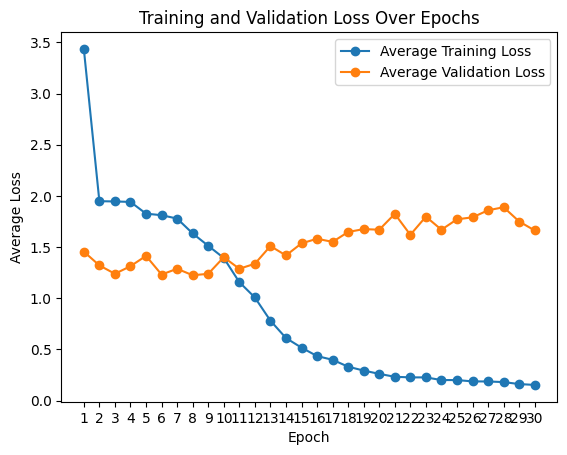

In [7]:
# Training the model
n_total_steps = len(trainloader)
avg_train_loss_over_epochs = []
avg_val_loss_over_epochs = []

for epoch in range(num_epochs):
    train_losses = []
    val_losses = []
    
    # Training loop
    model.train()
    for i, (images, labels) in tqdm(enumerate(trainloader), desc="Training Progress", total=len(trainloader)):
        # Move images and labels to device
        images = images.float()
        # images = images.permute(1, 0, 2, 3, 4)  # Change shape to [5, 10, 1, 224, 224]
        labels = labels.float()

        # Forward pass with autograd
        outputs = model(images).squeeze(1)
        loss = criterion(outputs, labels)
        tqdm.write(f"Epoch: {epoch+1}, Index: {i}, Loss: {loss.item():.4f}")

        # Backward pass and optimization
        optimizer.zero_grad()
        fabric.backward(loss)
        optimizer.step()
        # Store the loss
        train_losses.append(loss.item())
    
    # Store the average training loss for this epoch
    avg_train_loss_over_epochs.append(sum(train_losses) / len(train_losses))
    
    # Validation loop
    model.eval()
    with torch.no_grad():
        for images, labels in tqdm(valloader, desc="Validation Progress"):
            images = images.float()
            # images = images.permute(1, 0, 2, 3, 4)
            labels = labels.float()
            outputs = model(images).squeeze(1)
            loss = criterion(outputs, labels)
            print("Validation Loss: ", loss.item())
            val_losses.append(loss.item())
    
    # Store the average validation loss for this epoch
    avg_val_loss_over_epochs.append(sum(val_losses) / len(val_losses))

# Plot loss over epochs
plt.figure()
plt.plot(range(1, num_epochs + 1), avg_train_loss_over_epochs, label='Average Training Loss', marker='o')
plt.plot(range(1, num_epochs + 1), avg_val_loss_over_epochs, label='Average Validation Loss', marker='o')
plt.xticks(range(1, num_epochs + 1))  # Ensure x-axis includes all epoch numbers
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
plt.legend()
plt.title('Training and Validation Loss Over Epochs')
plt.show()

In [8]:
import math
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, root_mean_squared_error

# Test the model
model.eval()
testloader = torch.utils.data.DataLoader(dataset=testset, batch_size=batch_size, shuffle=False, num_workers=10)
testloader = fabric.setup_dataloaders(testloader)
test_losses = []
all_labels = []
all_outputs = []

with torch.no_grad():
    for images, labels in tqdm(testloader, desc="Testing Progress"):
        images = images.float()
        # images = images.permute(1, 0, 2, 3, 4)
        labels = labels.float()
        print("Label: ", labels)
        outputs = model(images).squeeze(1)
        print("Output: ", outputs)
        loss = criterion(outputs, labels)
        test_losses.append(loss.item())
        all_labels.extend(labels.cpu().numpy())
        all_outputs.extend(outputs.cpu().numpy())

avg_test_loss = sum(test_losses) / len(test_losses)
rmse = math.sqrt(avg_test_loss)
mse = mean_squared_error(all_labels, all_outputs)
mae = mean_absolute_error(all_labels, all_outputs)
r2 = r2_score(all_labels, all_outputs)

print(f'Average test loss: {avg_test_loss:.4f}')
print(f'RMSE: {rmse:.4f}')
print(f'MSE: {mse:.4f}')
print(f'MAE: {mae:.4f}')
print(f'R²: {r2:.4f}')

Testing Progress:   0%|          | 0/200 [00:00<?, ?it/s]

Label:  tensor([3.3330, 4.6670], device='cuda:0')
Output:  tensor([1.9688, 2.2656], device='cuda:0')
Label:  tensor([2.6670, 4.6670], device='cuda:0')
Output:  tensor([1.5000, 2.9062], device='cuda:0')
Label:  tensor([2.6670, 2.3330], device='cuda:0')
Output:  tensor([3.1719, 2.2188], device='cuda:0')
Label:  tensor([3.3330, 3.3330], device='cuda:0')
Output:  tensor([3.6562, 1.9375], device='cuda:0')
Label:  tensor([3.3330, 4.0000], device='cuda:0')
Output:  tensor([2.4375, 2.5469], device='cuda:0')
Label:  tensor([2.6670, 4.6670], device='cuda:0')
Output:  tensor([3.3438, 2.7969], device='cuda:0')
Label:  tensor([3.6670, 3.6670], device='cuda:0')
Output:  tensor([3.4062, 2.3281], device='cuda:0')
Label:  tensor([3.6670, 2.3330], device='cuda:0')
Output:  tensor([2.4062, 3.1094], device='cuda:0')
Label:  tensor([6., 3.], device='cuda:0')
Output:  tensor([2.7031, 2.5781], device='cuda:0')
Label:  tensor([3.0000, 2.3330], device='cuda:0')
Output:  tensor([2.7344, 2.1094], device='cuda:0'

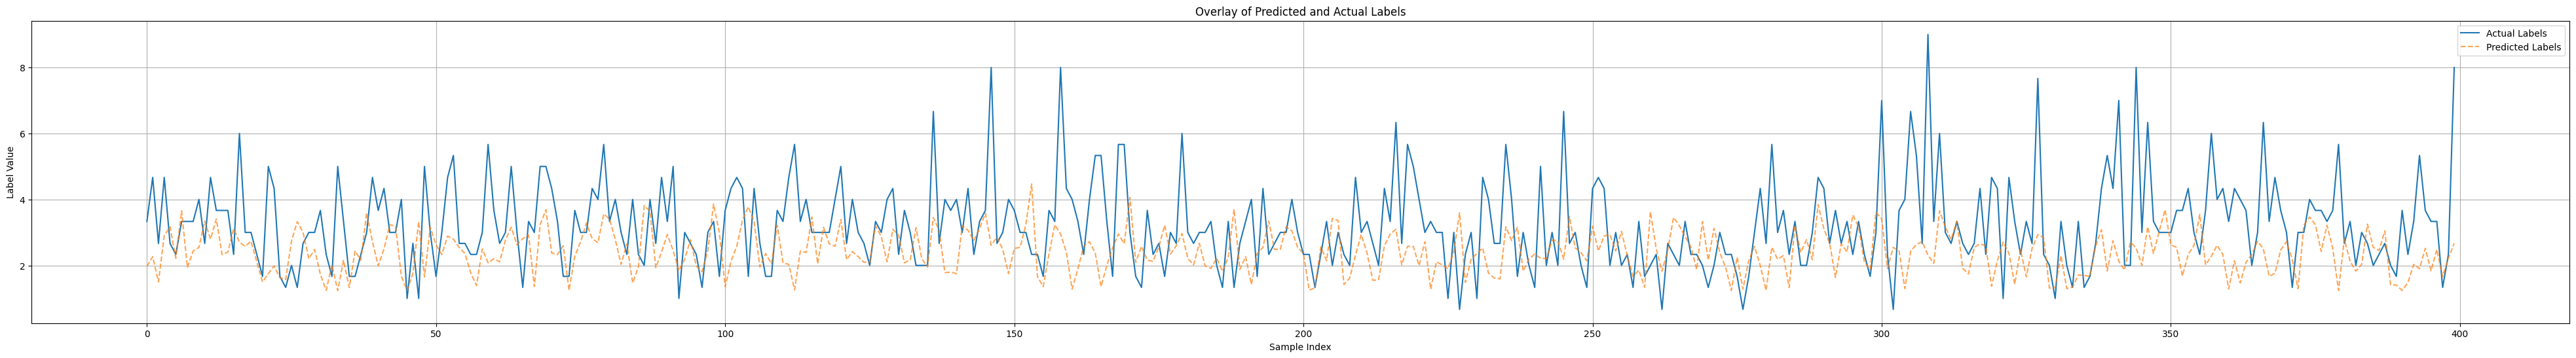

[1.96875, 2.265625, 1.5, 2.90625, 3.171875, 2.21875, 3.65625, 1.9375, 2.4375, 2.546875, 3.34375, 2.796875, 3.40625, 2.328125, 2.40625, 3.109375, 2.703125, 2.578125, 2.734375, 2.109375, 1.5, 1.75, 1.984375, 1.625, 1.5703125, 2.734375, 3.328125, 3.0, 2.203125, 2.484375, 1.7265625, 1.2421875, 2.015625, 1.234375, 2.15625, 1.328125, 2.4375, 2.15625, 3.59375, 2.71875, 1.9921875, 2.5, 3.234375, 3.1875, 1.671875, 1.2421875, 1.7578125, 3.328125, 1.6484375, 3.15625, 2.625, 2.328125, 2.890625, 2.796875, 2.546875, 2.359375, 1.7734375, 1.390625, 2.5, 2.078125, 2.203125, 2.109375, 2.765625, 3.15625, 2.625, 2.8125, 2.921875, 1.359375, 3.234375, 3.6875, 2.375, 2.328125, 2.59375, 1.2421875, 2.28125, 2.71875, 3.28125, 2.8125, 2.6875, 3.5625, 3.40625, 2.78125, 2.03125, 2.65625, 1.46875, 1.953125, 3.8125, 3.640625, 1.9296875, 2.40625, 2.9375, 2.453125, 1.84375, 2.1875, 2.78125, 1.984375, 1.8125, 2.453125, 3.859375, 2.984375, 1.3515625, 2.125, 2.578125, 3.375, 3.78125, 3.328125, 1.953125, 2.359375, 2.04687

In [9]:
plt.figure(figsize=(50, 6))

plt.plot(all_labels, '-', label='Actual Labels')
plt.plot(all_outputs, '--', label='Predicted Labels', alpha=0.7)

plt.xlabel('Sample Index')
plt.ylabel('Label Value')
plt.title('Overlay of Predicted and Actual Labels')
plt.legend()
plt.grid(True)
plt.show()
print(all_outputs)